## classify into two groups for VEP scores from Ensembl

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import requests
import scipy as sp

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, auc, confusion_matrix, matthews_corrcoef

## given new VEP list, get a new file combining GPCRdb mutation with VEP score

In [10]:
# read in all gene names
gene_list_raw =pd.read_csv("230323_EST_ENSG_GENE_new.csv")
gene_list_raw.rename(columns={'gene':'SYMBOL'},inplace=True)
gene_list_raw

,index,ENST,ENSG,protein,SYMBOL,Uniprot
0,0,ENST00000646641,ENSG00000267534,s1pr2_human,S1PR2,O95136
1,121,ENST00000547270,ENSG00000257138,t2r38_human,TAS2R38,P59533
2,219,ENST00000390675,ENSG00000256436,t2r31_human,TAS2R31,P59538
3,344,ENST00000539585,ENSG00000256188,t2r30_human,TAS2R30,P59541
4,483,ENST00000538986,ENSG00000255837,t2r20_human,TAS2R20,P59543
...,...,...,...,...,...,...
395,64029,ENST00000510937,ENSG00000226306,npy6r_human,NPY6R,Q99463
396,64030,ENST00000641193,ENSG00000279301,o2t11_human,OR2T11,Q8NH01
397,64031,ENST00000641732,ENSG00000172146,or1a1_human,OR1A1,Q9P1Q5
398,64032,ENST00000328890,ENSG00000183024,or1g1_human,OR1G1,P47890


In [4]:
vep_filtered_all = pd.read_csv('vep_filtered_all.csv')
vep_filtered_all

,protein,ENST,mutation_pos,exp_fold_change,mutation_from,mutation_to,vep_input
0,hrh1_human,ENST00000438284,37,-1.585,Ile,Val,ENST00000438284:p.Ile37Val
1,hrh1_human,ENST00000438284,38,1.000,Cys,Ser,ENST00000438284:p.Cys38Ser
2,hrh1_human,ENST00000438284,84,-2.513,Asn,Ser,ENST00000438284:p.Asn84Ser
3,hrh1_human,ENST00000438284,111,1.000,Ser,Ala,ENST00000438284:p.Ser111Ala
4,hrh1_human,ENST00000438284,111,1.585,Ser,Cys,ENST00000438284:p.Ser111Cys
...,...,...,...,...,...,...,...
11974,aa3r_human,ENST00000241356,274,-3.322,Asn,Ala,ENST00000241356:p.Asn274Ala
11975,aa3r_human,ENST00000241356,274,-1.328,Asn,Ala,ENST00000241356:p.Asn274Ala
11976,aa3r_human,ENST00000241356,282,-29.412,Tyr,Phe,ENST00000241356:p.Tyr282Phe
11977,aa3r_human,ENST00000241356,282,-7.752,Tyr,Phe,ENST00000241356:p.Tyr282Phe


In [2]:
# import the names of VEPs
VEP_list = ["SIFT",
"PolyPhen",
"BayesDel_addAF_score",
"BayesDel_noAF_score",
"CADD_phred",
"ClinPred_score",
"DANN_score",
"DEOGEN2_score",
"FATHMM_score",
"integrated_fitCons_score",
"LIST-S2_score",
"LRT_score",
"M-CAP_score",
"MVP_score",
"MetaLR_score",
"MetaRNN_score",
"MetaSVM_score",
"MutationAssessor_score",
"PROVEAN_score",
"PrimateAI_score",
"REVEL_score",
"VEST4_score",
"GERP++_RS",
"SiPhy_29way_logOdds",
"MutPred_score"]

In [5]:
df = pd.read_csv("vep_score_new_0328.txt",sep='\t')
df = df.rename(columns={'#Uploaded_variation':'vep_input'})
df = df.merge(vep_filtered_all,on=['vep_input'])
df

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,vep_input,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,phyloP17way_primate,phyloP17way_primate_rankscore,phyloP30way_mammalian,phyloP30way_mammalian_rankscore,protein,ENST,mutation_pos,exp_fold_change,mutation_from,mutation_to
0,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.618000,0.50648,1.176000,0.78918,lshr_human,ENST00000294954,572,-1.124,Ala,Val
1,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.618000,0.50648,1.176000,0.78918,lshr_human,ENST00000294954,572,-1.351,Ala,Val
2,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000401907.5,protein_coding,...,-,-,-,-,lshr_human,ENST00000294954,572,-1.124,Ala,Val
3,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000401907.5,protein_coding,...,-,-,-,-,lshr_human,ENST00000294954,572,-1.351,Ala,Val
4,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000403273.5,protein_coding,...,-,-,-,-,lshr_human,ENST00000294954,572,-1.124,Ala,Val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73015,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,-,5ht2c_human,ENST00000276198,368,2.601,Tyr,Phe
73016,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,-,5ht2c_human,ENST00000276198,368,-1.401,Tyr,Phe
73017,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,-,5ht2c_human,ENST00000276198,368,4.400,Tyr,Phe
73018,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,-,5ht2c_human,ENST00000276198,368,-1.629,Tyr,Phe


In [6]:
# select the rows based on Feature(ENST id)
df['ENST_id'] = df['Feature'].str.split('.',expand=True)[0]
df

,vep_input,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,phyloP17way_primate_rankscore,phyloP30way_mammalian,phyloP30way_mammalian_rankscore,protein,ENST,mutation_pos,exp_fold_change,mutation_from,mutation_to,ENST_id
0,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.50648,1.176000,0.78918,lshr_human,ENST00000294954,572,-1.124,Ala,Val,ENST00000294954
1,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.50648,1.176000,0.78918,lshr_human,ENST00000294954,572,-1.351,Ala,Val,ENST00000294954
2,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000401907.5,protein_coding,...,-,-,-,lshr_human,ENST00000294954,572,-1.124,Ala,Val,ENST00000401907
3,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000401907.5,protein_coding,...,-,-,-,lshr_human,ENST00000294954,572,-1.351,Ala,Val,ENST00000401907
4,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,3_prime_UTR_variant,MODIFIER,LHCGR,ENSG00000138039,Transcript,ENST00000403273.5,protein_coding,...,-,-,-,lshr_human,ENST00000294954,572,-1.124,Ala,Val,ENST00000403273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73015,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,5ht2c_human,ENST00000276198,368,2.601,Tyr,Phe,ENSR00001293461
73016,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,5ht2c_human,ENST00000276198,368,-1.401,Tyr,Phe,ENSR00001293461
73017,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,5ht2c_human,ENST00000276198,368,4.400,Tyr,Phe,ENSR00001293461
73018,ENST00000276198:p.Tyr368Phe,X:114907141-114907141,T,regulatory_region_variant,MODIFIER,-,-,RegulatoryFeature,ENSR00001293461,enhancer,...,-,-,-,5ht2c_human,ENST00000276198,368,-1.629,Tyr,Phe,ENSR00001293461


### data filtering

In [7]:
# only keep missense variants
df1 = df[df['Consequence'].str.contains('missense')]


In [8]:
df1 = df1[~df1['Amino_acids'].isna()]

In [11]:
# only keep the data that are generated from the transcripts in out list(the transcrips in our list are all the longest transcripts of each protein)
df1 = df1[df1['ENST_id'].isin(gene_list_raw['ENST'].tolist())]

In [12]:
df1 = df1.drop_duplicates(subset=['vep_input'],keep='first')
df1

,vep_input,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,phyloP17way_primate_rankscore,phyloP30way_mammalian,phyloP30way_mammalian_rankscore,protein,ENST,mutation_pos,exp_fold_change,mutation_from,mutation_to,ENST_id
0,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.50648,1.176000,0.78918,lshr_human,ENST00000294954,572,-1.124,Ala,Val,ENST00000294954
10,ENST00000294954:p.Ala593Pro,2:48688020-48688020,G,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.26987,1.026000,0.45946,lshr_human,ENST00000294954,593,-5.000,Ala,Pro,ENST00000294954
15,ENST00000294954:p.Asp564Gly,2:48688106-48688106,C,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.47794,1.138000,0.64695,lshr_human,ENST00000294954,564,-1.639,Asp,Gly,ENST00000294954
60,ENST00000294954:p.Asp578Gly,2:48688064-48688064,C,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.47794,1.138000,0.64695,lshr_human,ENST00000294954,578,-4.000,Asp,Gly,ENST00000294954
115,ENST00000294954:p.Asp578His,2:48688065-48688065,G,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.26987,1.026000,0.45946,lshr_human,ENST00000294954,578,4.000,Asp,His,ENST00000294954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72924,ENST00000276198:p.Cys360Ala,X:114907116-114907117,GC,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,-,-,-,5ht2c_human,ENST00000276198,360,1.182,Cys,Ala,ENST00000276198
72932,ENST00000276198:p.Ser361Ala,X:114907119-114907119,G,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.47794,1.049000,0.51903,5ht2c_human,ENST00000276198,361,-6.211,Ser,Ala,ENST00000276198
72948,ENST00000276198:p.Tyr368Ala,X:114907140-114907141,GC,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,-,-,-,5ht2c_human,ENST00000276198,368,-1.282,Tyr,Ala,ENST00000276198
72972,ENST00000276198:p.Tyr368Cys,X:114907141-114907141,G,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.84096,1.207000,0.84665,5ht2c_human,ENST00000276198,368,-1.742,Tyr,Cys,ENST00000276198


In [13]:
len(np.unique(df1['ENST_id'].tolist()))

66

### here found that only 66 GPCRs exist, why 3 GPCRs disappear? 

In [14]:
g0 = np.unique(vep_filtered_all['ENST'].tolist())
g1 = np.unique(df1['ENST_id'].tolist())

# Convert lists to sets
set1 = set(g0)
set2 = set(g1)

# Get the overlap (common elements)
overlap = set1.intersection(set2)

# Get the difference (unique elements)
difference = set1.symmetric_difference(set2)

# Convert sets back to lists
overlap_list = list(overlap)
difference_list = list(difference)

print("Overlap: ", overlap_list)
print("Difference: ", difference_list)

Overlap:  ['ENST00000449590', 'ENST00000306675', 'ENST00000433765', 'ENST00000395052', 'ENST00000340177', 'ENST00000398285', 'ENST00000258400', 'ENST00000369947', 'ENST00000306960', 'ENST00000326306', 'ENST00000521530', 'ENST00000345060', 'ENST00000445907', 'ENST00000362072', 'ENST00000305447', 'ENST00000294954', 'ENST00000019103', 'ENST00000296140', 'ENST00000374472', 'ENST00000383263', 'ENST00000620793', 'ENST00000241356', 'ENST00000373256', 'ENST00000646607', 'ENST00000323865', 'ENST00000305988', 'ENST00000392370', 'ENST00000325123', 'ENST00000339381', 'ENST00000374619', 'ENST00000393597', 'ENST00000304374', 'ENST00000438284', 'ENST00000276393', 'ENST00000272847', 'ENST00000393752', 'ENST00000400888', 'ENST00000292303', 'ENST00000369295', 'ENST00000295683', 'ENST00000326139', 'ENST00000299766', 'ENST00000256906', 'ENST00000318507', 'ENST00000241393', 'ENST00000304222', 'ENST00000400723', 'ENST00000542664', 'ENST00000282753', 'ENST00000336152', 'ENST00000590918', 'ENST00000276198', '

After checking with the data in Uniprot, found that the mutation info of these three ada1d_human,drd4_human,ada2a_human not match with Uniprot info.
Asked Jimmy, got response:
"Some of the PDB receive updates that are not tracked in GPCRdb, so it is very possible that GPCRdb has a previous version of the mentioned PDB file stored in its database, whereas a new one became available online and was not correctly updated in our database. This could happen and we are currently working on a solution to avoid this problem. We will look into this discrepancy in the next days, thank you for raising the issue."

### keep doing subsequent analysis

In [30]:
# # filter out the data that is '-' in column “MutationTaster_AAE”(they don't have most of the scores)
# df2  = df1[df1['MutationTaster_AAE']!='-']
# df2

,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,phastCons17way_primate_rankscore,phastCons30way_mammalian,phastCons30way_mammalian_rankscore,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP17way_primate,phyloP17way_primate_rankscore,phyloP30way_mammalian,phyloP30way_mammalian_rankscore,ENST_id
0,ENST00000294954:p.Ala572Val,2:48688082-48688082,A,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.79791,0.999000,0.70432,10.003000,0.99689,0.618000,0.50648,1.176000,0.78918,ENST00000294954
5,ENST00000294954:p.Ala593Pro,2:48688020-48688020,G,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.79791,1.000000,0.86279,5.017000,0.63813,0.549000,0.26987,1.026000,0.45946,ENST00000294954
10,ENST00000294954:p.Asp564Gly,2:48688106-48688106,C,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.73285,0.992000,0.54103,8.017000,0.88732,0.609000,0.47794,1.138000,0.64695,ENST00000294954
15,ENST00000294954:p.Asp578Gly,2:48688064-48688064,C,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.52637,0.903000,0.37846,8.017000,0.88732,0.609000,0.47794,1.138000,0.64695,ENST00000294954
20,ENST00000294954:p.Asp578His,2:48688065-48688065,G,missense_variant,MODERATE,LHCGR,ENSG00000138039,Transcript,ENST00000294954.12,protein_coding,...,0.49849,0.777000,0.32840,5.054000,0.64097,0.549000,0.26987,1.026000,0.45946,ENST00000294954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18755,ENST00000276198:p.Trp324Leu,X:114907009-114907009,T,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.73285,1.000000,0.86279,9.923000,0.98785,0.618000,0.50648,1.083000,0.53824,ENST00000276198
18787,ENST00000276198:p.Tyr358Phe,X:114907111-114907111,T,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.37229,0.984000,0.49151,9.252000,0.94679,0.691000,0.84096,1.207000,0.84665,ENST00000276198
18795,ENST00000276198:p.Ser361Ala,X:114907119-114907119,G,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.38590,0.951000,0.41969,7.955000,0.87381,0.609000,0.47794,1.049000,0.51903,ENST00000276198
18803,ENST00000276198:p.Tyr368Cys,X:114907141-114907141,G,missense_variant,MODERATE,HTR2C,ENSG00000147246,Transcript,ENST00000276198.6,protein_coding,...,0.36519,0.941000,0.40850,9.252000,0.94679,0.691000,0.84096,1.207000,0.84665,ENST00000276198


In [15]:
extract_list = ["vep_input","Protein_position","SYMBOL","Amino_acids",'protein']+VEP_list
# extract_list


In [16]:
# extract corresponding vep columns from the original dataframe
df2 = df1.loc[:,extract_list]
# # in order to merge with data from gpcrdb, we need to transfrom the 'SYMBOL' column(make them the same format as in gpcrdb)
# df2["protein"] = df2["SYMBOL"].apply(lambda x: x.lower()+'_human')
AA_type = df2['Amino_acids'].str.split('/',expand=True)
df2['mutation_from']=AA_type.iloc[:,0]
df2['mutation_to']=AA_type.iloc[:,1]

#and change the column name'protein position' to 'AA_pos'
df2.rename(columns={'Protein_position':'mutation_pos'},inplace=True)
df2['mutation_pos'] = df2['mutation_pos'].astype('int64')
# drop duplicates
# df3 = df2.drop_duplicates(subset=['#Uploaded_variation'], keep='first', inplace=False)
df2

,vep_input,mutation_pos,SYMBOL,Amino_acids,protein,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,...,MutationAssessor_score,PROVEAN_score,PrimateAI_score,REVEL_score,VEST4_score,GERP++_RS,SiPhy_29way_logOdds,MutPred_score,mutation_from,mutation_to
0,ENST00000294954:p.Ala572Val,572,LHCGR,A/V,lshr_human,deleterious(0),probably_damaging(0.998),0.271259,0.151868,28.4,...,"2.685,.","-3.47,-3.51",0.647560358047,"0.613,0.613","0.778,0.789",5.68,18.7926,0.935,A,V
10,ENST00000294954:p.Ala593Pro,593,LHCGR,A/P,lshr_human,deleterious(0),probably_damaging(1),0.263129,0.14019,25.7,...,"3.28,.","-3.34,-3.56",0.664010286331,"0.595,0.595","0.897,0.938",5.68,18.7926,0.886,A,P
15,ENST00000294954:p.Asp564Gly,564,LHCGR,D/G,lshr_human,deleterious(0),probably_damaging(0.999),0.302076,0.196135,28.5,...,"3.49,.","-6.01,-5.99",0.665593266487,"0.842,0.842","0.923,0.954",5.68,15.1242,0.897,D,G
60,ENST00000294954:p.Asp578Gly,578,LHCGR,D/G,lshr_human,deleterious(0),possibly_damaging(0.685),0.294007,0.184544,27.4,...,"3.715,.","-5.96,-6.04",0.658861994743,"0.756,0.756","0.84,0.927",5.68,15.1242,0.936,D,G
115,ENST00000294954:p.Asp578His,578,LHCGR,D/H,lshr_human,deleterious(0),probably_damaging(0.952),0.275656,0.158184,24.6,...,"3.715,.","-5.94,-6.02",0.713786900043,"0.500,0.500","0.828,0.864",4.8,14.1045,0.877,D,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72924,ENST00000276198:p.Cys360Ala,360,HTR2C,C/A,5ht2c_human,deleterious(0.02),benign(0.015),-,-,-,...,-,-,-,-,-,-,-,-,C,A
72932,ENST00000276198:p.Ser361Ala,361,HTR2C,S/A,5ht2c_human,deleterious(0),probably_damaging(0.998),0.270807,0.151219,24.3,...,".,.","-2.26,-2.26",0.640748023987,"0.821,0.821","0.623,0.65",5.13,11.8568,0.886,S,A
72948,ENST00000276198:p.Tyr368Ala,368,HTR2C,Y/A,5ht2c_human,deleterious(0),probably_damaging(1),-,-,-,...,-,-,-,-,-,-,-,-,Y,A
72972,ENST00000276198:p.Tyr368Cys,368,HTR2C,Y/C,5ht2c_human,deleterious(0),probably_damaging(1),0.622314,0.656134,24.9,...,".,.","-7.09,-7.09",0.834922552109,"0.881,0.881","0.964,0.961",5.13,11.8568,0.867,Y,C


In [96]:
df2.to_csv('gpcr_valid_missense.csv',index=False)

### Completeness table

In [17]:
# Completeness:
def completeness(VEP_list,df):
    stat_df = pd.DataFrame()
    row = 0
    for i in range(len(VEP_list)): 
        vep = VEP_list[i]
        count_vep_pred = df[df[vep]!='-'].shape[0]
        stat_df.loc[row,'vep'] = vep
        # 21908 is the number of mutations I put into Emsembl
        stat_df.loc[row,'Variants with prediction'] = str(count_vep_pred)+'/'+str(df.shape[0])
        stat_df.loc[row,'Variants with prediction(%)'] = str("{:.2f}".format(count_vep_pred/df.shape[0]*100))+"%"
        row = row + 1

    return stat_df

### now get the information of number of variants with valid prediction /  total variants

In [97]:
stat_df = completeness(VEP_list,df1)
stat_df

,vep,Variants with prediction,Variants with prediction(%)
0,SIFT,2485/2485,100.00%
1,PolyPhen,2485/2485,100.00%
2,BayesDel_addAF_score,1302/2485,52.39%
3,BayesDel_noAF_score,1302/2485,52.39%
4,CADD_phred,1302/2485,52.39%
5,ClinPred_score,1302/2485,52.39%
6,DANN_score,1302/2485,52.39%
7,DEOGEN2_score,1293/2485,52.03%
8,FATHMM_score,1301/2485,52.35%
9,integrated_fitCons_score,1266/2485,50.95%


In [98]:
stat_df.to_csv("completeness_table_GPCRdb.csv",index=False)

In [ ]:
# stat_df = pd.DataFrame()
# row = 0
# for i in range(len(VEP_list)): 
#     vep = VEP_list[i]
#     count_vep_pred = df1[df1[vep]!='-'].shape[0]
#     stat_df.loc[row,'vep'] = vep
#     # 3068 is the number of mutations I put into Emsembl
#     stat_df.loc[row,'Variants with prediction'] = str(count_vep_pred)+"/3068"
#     stat_df.loc[row,'Variants with prediction(%)'] = str("{:.2f}".format(count_vep_pred/3068*100))+"%"
#     row = row + 1

# stat_df

### merge with gpcrdb data and output as a csv file

In [376]:
# read in gpcrdb data
gpcrdb = pd.read_csv("gpcr_filtered_mutants_0217.csv")
# gpcrdb.rename(columns={'mutation_from':'wt_AA','mutation_to':'mt_AA'},inplace=True)
gpcrdb

,Unnamed: 0,reference,protein,mutation_pos,mutation_from,mutation_to,ligand_name,ligand_idtype,ligand_id,ligand_class,...,exp_mu_effect_value,exp_fold_change,exp_mu_effect_qual,exp_mu_effect_ligand_prop,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist
0,0,8903934,hrh1_human,194,T,A,(S)-cetirizine,ChEMBL Compound ID,CHEMBL1334217,Binding - unknown pharmacological activity,...,8.000,-10.000,NaN,NaN,[3H]-mepyramine (radioligand),0.0,0.0,NaN,0.0,NaN
1,1,15033376,hrh1_human,432,F,A,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,30.000,23.077,NaN,NaN,[3H]-mepyramine (radioligand),0.0,0.0,NaN,0.0,NaN
2,2,8198587,hrh1_human,198,N,A,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,0.790,1.362,NaN,NaN,[3H]-mepyramine (radioligand),102.6,0.0,NaN,0.0,NaN
3,3,17959710,hrh1_human,420,I,E,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,6.700,-5.000,NaN,NaN,[3H]-mepyramine (radioligand),9.1,0.0,NaN,0.0,NaN
4,5,15626750,hrh1_human,433,I,V,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,4.500,-1.585,NaN,NaN,[3H]-mepyramine (radioligand),81.8,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12017,455,10.1021/jm020211+,aa3r_human,243,W,A,Compound39,SMILES,CCCC1C(=C(CC)N=C(c2ccccc2)C1(CCC)C([O-])=O)C(=...,Inverse agonist,...,2150.000,9.034,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN
12018,456,10.1124/mol.63.5.1021,aa3r_human,243,W,A,DU124183,PubChem CID,10426659,Allosteric inverse agonist,...,3.600,3.000,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN
12019,458,10.1021/jm050968b,aa3r_human,272,H,D,CID85116573,PubChem CID,85116573,Full agonist,...,0.850,-11.236,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN
12020,459,10.1124/mol.63.5.1021,aa3r_human,244,L,A,DU124183,PubChem CID,10426659,Allosteric inverse agonist,...,2.100,1.750,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN


In [377]:
# merge according to protein name, mutation position and mutations
VEPwithGPCR = pd.merge(df2,gpcrdb,on=['protein','mutation_pos','mutation_from','mutation_to'])
VEPwithGPCR

,vep_input,mutation_pos,SYMBOL,Amino_acids,protein,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,...,exp_mu_effect_value,exp_fold_change,exp_mu_effect_qual,exp_mu_effect_ligand_prop,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist
0,ENST00000294954:p.Ala572Val,572,LHCGR,A/V,lshr_human,deleterious(0),probably_damaging(0.998),0.271259,0.151868,28.4,...,74.00,1.351,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
1,ENST00000294954:p.Ala572Val,572,LHCGR,A/V,lshr_human,deleterious(0),probably_damaging(0.998),0.271259,0.151868,28.4,...,89.00,1.124,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
2,ENST00000294954:p.Ala593Pro,593,LHCGR,A/P,lshr_human,deleterious(0),probably_damaging(1),0.263129,0.14019,25.7,...,20.00,5.000,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
3,ENST00000294954:p.Asp564Gly,564,LHCGR,D/G,lshr_human,deleterious(0),probably_damaging(0.999),0.302076,0.196135,28.5,...,74.00,1.351,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
4,ENST00000294954:p.Asp564Gly,564,LHCGR,D/G,lshr_human,deleterious(0),probably_damaging(0.999),0.302076,0.196135,28.5,...,73.00,1.370,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,2.10,1.628,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN
9736,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,13.00,-3.922,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN
9737,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,2.64,3.385,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
9738,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,25.00,-4.405,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN


In [477]:
len(np.unique(VEPwithGPCR['protein'].tolist()))

66

In [61]:
VEPwithGPCR.to_csv("VEPwithGPCR_0328.csv",index=False)

## Given new VEPwithGPCR, calculate the accuracy, precision....for each VEP

In [269]:
VEPwithGPCR = pd.read_csv('VEPwithGPCR_0328.csv')
VEPwithGPCR

,vep_input,mutation_pos,SYMBOL,Amino_acids,protein,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,...,exp_mu_effect_value,exp_fold_change,exp_mu_effect_qual,exp_mu_effect_ligand_prop,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist
0,ENST00000294954:p.Ala572Val,572,LHCGR,A/V,lshr_human,deleterious(0),probably_damaging(0.998),0.271259,0.151868,28.4,...,89.0,-1.124,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
1,ENST00000294954:p.Ala572Val,572,LHCGR,A/V,lshr_human,deleterious(0),probably_damaging(0.998),0.271259,0.151868,28.4,...,74.0,-1.351,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
2,ENST00000294954:p.Ala593Pro,593,LHCGR,A/P,lshr_human,deleterious(0),probably_damaging(1),0.263129,0.14019,25.7,...,20.0,-5.000,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
3,ENST00000294954:p.Asp564Gly,564,LHCGR,D/G,lshr_human,deleterious(0),probably_damaging(0.999),0.302076,0.196135,28.5,...,61.0,-1.639,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
4,ENST00000294954:p.Asp564Gly,564,LHCGR,D/G,lshr_human,deleterious(0),probably_damaging(0.999),0.302076,0.196135,28.5,...,27.0,-3.704,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,188.0,2.601,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN
9705,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,14.0,-1.401,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN
9706,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,25.0,4.400,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN
9707,ENST00000276198:p.Tyr368Phe,368,HTR2C,Y/F,5ht2c_human,deleterious(0),probably_damaging(1),0.429525,0.379207,24.0,...,2.1,-1.629,NaN,NaN,[3H]Mesulergine,0.0,0.0,NaN,0.0,NaN


In [701]:
sthresh = pd.read_csv('score_threshold.csv')
sthresh

,VEP,threshold,greater than
0,SIFT,0.050000,0
1,PolyPhen,0.500000,1
2,BayesDel_addAF_score,0.069265,1
3,BayesDel_noAF_score,-0.057010,1
4,CADD_phred,20.000000,1
5,ClinPred_score,0.500000,1
6,DANN_score,0.990000,1
7,DEOGEN2_score,0.500000,1
8,FATHMM_score,-1.500000,0
9,integrated_fitCons_score,0.400000,1


In [702]:
# import the names of VEPs
VEP_list = ["SIFT",
"PolyPhen",
"BayesDel_addAF_score",
"BayesDel_noAF_score",
"CADD_phred",
"ClinPred_score",
"DANN_score",
"DEOGEN2_score",
"FATHMM_score",
"integrated_fitCons_score",
"LIST-S2_score",
"LRT_score",
"M-CAP_score",
"MVP_score",
"MetaLR_score",
"MetaRNN_score",
"MetaSVM_score",
"MutationAssessor_score",
"PROVEAN_score",
"PrimateAI_score",
"REVEL_score",
"VEST4_score",
"GERP++_RS",
"SiPhy_29way_logOdds",
"MutPred_score"]

In [169]:
check_label = VEPwithGPCR.copy(deep=True)
check_label['foldchange_group'] = check_label['exp_fold_change'].apply(lambda x: 1 if x < -2 else (1 if x > 2 else 0))
check_label['foldchange_group'].value_counts()

1    5039
0    4701
Name: foldchange_group, dtype: int64

In [71]:
la = check_label['foldchange_group']
la.value_counts()[[0,1]]

0    4700
1    5009
Name: foldchange_group, dtype: int64

### calculating the performance of Ensembl VEPs

In [699]:
def get_performance(VEPwithGPCR,aggregation,fc,general=True):
    # whether to do aggregation
    # aggregation = 'mean'
    print('start: ',aggregation)
    perf_df = pd.DataFrame()

    row = 0
    for i in range(len(VEP_list)):  
        vep = sthresh['VEP'][i]
        print('processing VEP: ',vep)
        thresh_value = sthresh['threshold'][i]
        thresh_greather = sthresh['greater than'][i]

        temp1 = VEPwithGPCR[VEPwithGPCR[vep]!='-'][['mutation_pos','SYMBOL','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
        p1 = re.compile(r'[(](.*?)[)]', re.S)
        if vep == 'SIFT' or vep == 'PolyPhen':
            temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
        elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
            temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
            temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
            temp1[vep] = temp2
            temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
        temp1[vep] = temp1[vep].astype(float)
          
        if thresh_greather==1:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x > thresh_value else 0)
        else:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x < thresh_value else 0)
        

        temp1['foldchange_group'] = temp1['exp_fold_change'].apply(lambda x: 1 if x < -fc else (1 if x > fc else 0))

        if aggregation == 'mean':
            ag_df = temp1.groupby(by=["SYMBOL","mutation_pos","Amino_acids"]).mean()[['vep_group','foldchange_group']]
            ag_df['ag_fc_group'] = (ag_df['foldchange_group'] >= 0.3).astype(int)
            exp_labels = ag_df['ag_fc_group']
            pred_labels = ag_df['vep_group'].astype(int)
        
        elif aggregation == 'max':
            ag_df = temp1.groupby(by=["SYMBOL","mutation_pos","Amino_acids"]).max()[['vep_group','foldchange_group']]
            exp_labels = ag_df['foldchange_group']
            pred_labels = ag_df['vep_group']   

        else:
            exp_labels = temp1['foldchange_group']
            pred_labels = temp1['vep_group']
            
        


        # Calculate accuracy
        accuracy = accuracy_score(exp_labels, pred_labels)
        # Calculate precision, recall and F1-score
        precision = precision_score(exp_labels, pred_labels)
        recall = recall_score(exp_labels, pred_labels)
        f1 = f1_score(exp_labels, pred_labels)

        # calculate Matthews Correlation Coefficient
        mcc = matthews_corrcoef(exp_labels, pred_labels)


        # store in df
        perf_df.loc[row,'vep'] = vep
        perf_df.loc[row,'accuracy'] = accuracy
        perf_df.loc[row,'precision'] = precision
        perf_df.loc[row,'f1-score'] = f1
        perf_df.loc[row,'mcc'] = mcc

        
        if general:
            # calculate FPR and TPR
            fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)
            # calculate AUCROC
            auc_roc = auc(fpr, tpr)
            # Calculate confusion matrix
            tn, fp, fn, tp = confusion_matrix(exp_labels, pred_labels).ravel()

            # Calculate specificity and sensitivity
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            perf_df.loc[row,'specificity'] = specificity
            perf_df.loc[row,'sensitivity'] = sensitivity
            perf_df.loc[row,'AUC'] = auc_roc
            perf_df.loc[row,'#tp/#fp'] = str(tp)+'/'+str(fp)
            perf_df.loc[row,'#tn/#fn'] = str(tn)+'/'+str(fn)
            perf_df.loc[row,'#exp_negative'] = str(exp_labels.value_counts()[[0,1]][0])
            perf_df.loc[row,'#exp_positive'] = str(exp_labels.value_counts()[[0,1]][1])
            perf_df.loc[row,'#pred_negative'] = str(pred_labels.value_counts()[[0,1]][0])
            perf_df.loc[row,'#pred_positive'] = str(pred_labels.value_counts()[[0,1]][1])
        row = row +1

    return perf_df


In [703]:
perf_df_AG_max = get_performance(VEPwithGPCR,'max',2)
perf_df_AG_max

start:  max
processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing VEP:  DEOGEN2_score
processing VEP:  FATHMM_score
processing VEP:  integrated_fitCons_score
processing VEP:  LIST-S2_score
processing VEP:  LRT_score
processing VEP:  M-CAP_score
processing VEP:  MVP_score
processing VEP:  MetaLR_score
processing VEP:  MetaRNN_score
processing VEP:  MetaSVM_score
processing VEP:  MutationAssessor_score
processing VEP:  PROVEAN_score
processing VEP:  PrimateAI_score
processing VEP:  REVEL_score
processing VEP:  VEST4_score
processing VEP:  GERP++_RS
processing VEP:  SiPhy_29way_logOdds
processing VEP:  MutPred_score


,vep,accuracy,precision,f1-score,mcc,specificity,sensitivity,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,SIFT,0.646204,0.713143,0.740214,0.189618,0.412178,0.769420,0.590799,1248/502,352/374,854,1622,726,1750
1,PolyPhen,0.615913,0.713016,0.702534,0.161122,0.470726,0.692355,0.581541,1123/452,402/499,854,1622,901,1575
2,BayesDel_addAF_score,0.559165,0.683735,0.614344,0.115294,0.561587,0.557740,0.559663,454/210,269/360,479,814,629,664
3,BayesDel_noAF_score,0.548337,0.694257,0.584637,0.123144,0.622129,0.504914,0.563522,411/181,298/403,479,814,701,592
4,CADD_phred,0.624130,0.660470,0.735294,0.124361,0.275574,0.829238,0.552406,675/347,132/139,479,814,271,1022
5,ClinPred_score,0.623357,0.663664,0.731384,0.130238,0.298539,0.814496,0.556517,663/336,143/151,479,814,294,999
6,DANN_score,0.588554,0.676692,0.669975,0.123960,0.461378,0.663391,0.562384,540/258,221/274,479,814,495,798
7,DEOGEN2_score,0.466667,0.718182,0.480730,0.054219,0.694079,0.361280,0.527680,237/93,211/419,304,656,630,330
8,FATHMM_score,0.402477,0.581673,0.274436,-0.048375,0.780793,0.179582,0.480188,146/105,374/667,479,813,1041,251
9,integrated_fitCons_score,0.613365,0.617978,0.760118,-0.055874,0.002096,0.987179,0.494638,770/476,1/10,477,780,11,1246


### calculating the performance of other VEPs outside Ensembl

In [697]:
def get_performance_other(vep_gpcr_df,vep,aggregation,fc,general=True):
    
    if vep == 'VESPAl':
        # VESPAl into two classifications: >=0.5(positive) <0.5(negative)
        vep_gpcr_df['vep_group'] = vep_gpcr_df[vep].apply(lambda x: 1 if x > 0.5 else 0)
    elif vep == 'Dynamut2':
         # ddg into two classifications: >1 or <1(positive) [-1,1] (negative)
        vep_gpcr_df['vep_group'] = vep_gpcr_df[vep].apply(lambda x: 1 if x < 0 else 0) 
    elif vep == 'FoldX':
         # ddg into two classifications: >1 or <1(positive) [-1,1] (negative)
        vep_gpcr_df['vep_group'] = vep_gpcr_df[vep].apply(lambda x: 1 if x < 1.5 else 0) 

    elif vep == 'RaSP':
         # ddg into two classifications: >1 or <1(positive) [-1,1] (negative)
        vep_gpcr_df['vep_group'] = vep_gpcr_df[vep].apply(lambda x: 1 if x < 2.5 else 0)    
    
    # vep_gb_df['BETA_group'] = vep_gb_df['BETA'].apply(lambda x: 1 if x < -2 else (1 if x > 2 else 0))
    vep_gpcr_df['foldchange_group'] = vep_gpcr_df['exp_fold_change'].apply(lambda x: 1 if x < -fc else (1 if x > fc else 0))


    # aggregation = 'mean'

    if aggregation == 'mean':
        ag_df = vep_gpcr_df.groupby(by=["protein","mutation_pos","mutation_from","mutation_to"])[['vep_group','foldchange_group']].mean()
        ag_df['ag_fc_group'] = (ag_df['foldchange_group'] >= 0.3).astype(int)
        exp_labels = ag_df['ag_fc_group']
        pred_labels = ag_df['vep_group'].astype(int)

    elif aggregation == 'max':
        ag_df = vep_gpcr_df.groupby(by=["protein","mutation_pos","mutation_from","mutation_to"])[['vep_group','foldchange_group']].max()
        exp_labels = ag_df['foldchange_group']
        pred_labels = ag_df['vep_group']   

    else:
        exp_labels = vep_gpcr_df['foldchange_group']
        pred_labels = vep_gpcr_df['vep_group']
    
    row = 0
    perf_df = pd.DataFrame()


    # Calculate accuracy
    accuracy = accuracy_score(exp_labels, pred_labels)
    # Calculate precision, recall and F1-score
    precision = precision_score(exp_labels, pred_labels)
    recall = recall_score(exp_labels, pred_labels)
    f1 = f1_score(exp_labels, pred_labels)
    # calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(exp_labels, pred_labels)


    # store in df
    perf_df.loc[row,'vep'] = vep
    perf_df.loc[row,'accuracy'] = accuracy
    perf_df.loc[row,'precision'] = precision
    perf_df.loc[row,'f1-score'] = f1
    perf_df.loc[row,'mcc'] = mcc

    if general:
        # calculate FPR and TPR
        fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)

        # calculate AUCROC
        auc_roc = auc(fpr, tpr)
        perf_df.loc[row,'AUC'] = auc_roc
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(exp_labels, pred_labels).ravel()
        # Calculate specificity and sensitivity
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        perf_df.loc[row,'specificity'] = specificity
        perf_df.loc[row,'sensitivity'] = sensitivity
        perf_df.loc[row,'#tp/#fp'] = str(tp)+'/'+str(fp)
        perf_df.loc[row,'#tn/#fn'] = str(tn)+'/'+str(fn)
        perf_df.loc[row,'#exp_negative'] = str(exp_labels.value_counts()[[0,1]][0])
        perf_df.loc[row,'#exp_positive'] = str(exp_labels.value_counts()[[0,1]][1])
        perf_df.loc[row,'#pred_negative'] = str(pred_labels.value_counts()[[0,1]][0])
        perf_df.loc[row,'#pred_positive'] = str(pred_labels.value_counts()[[0,1]][1])
    return perf_df


VESPA

In [32]:
VESPAwithGPCR = pd.read_csv('GPCR_VESPAI_df.csv')
VESPAwithGPCR

,Unnamed: 0,reference,protein,mutation_pos,mutation_from,mutation_to,ligand_name,ligand_idtype,ligand_id,ligand_class,...,exp_mu_effect_qual,exp_mu_effect_ligand_prop,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist,Uniprot_ID,VESPAl
0,22,15626750,hrh1_human,37,I,V,Cetirizine,ChEMBL Compound ID,CHEMBL1000,Binding - unknown pharmacological activity,...,NaN,NaN,[3H]-mepyramine (radioligand),94.2,0.0,NaN,0.0,NaN,P35367,0.353884
1,78,15626750,hrh1_human,37,I,V,HP-HA,ChEMBL Compound ID,CHEMBL264491,Binding - unknown pharmacological activity,...,NaN,NaN,[3H]-mepyramine (radioligand),94.2,0.0,NaN,0.0,NaN,P35367,0.353884
2,106,15626750,hrh1_human,37,I,V,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,NaN,NaN,[3H]-mepyramine (radioligand),94.2,0.0,NaN,0.0,NaN,P35367,0.353884
3,164,15626750,hrh1_human,37,I,V,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,NaN,NaN,[3H]-mepyramine (radioligand),94.2,0.0,NaN,0.0,NaN,P35367,0.353884
4,210,15626750,hrh1_human,37,I,V,HP-HP,SMILES,C1(CCNCCC2=CNC(CCC(C3=CC=CC=C3)C4=CC=CC=C4)=N2...,Binding - unknown pharmacological activity,...,NaN,NaN,[3H]-mepyramine (radioligand),94.2,0.0,NaN,0.0,NaN,P35367,0.353884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,437,10.1021/jm050968b,aa3r_human,272,H,D,CID75022483,PubChem CID,75022483,Full agonist,...,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN,P0DMS8,0.563917
9705,439,10.1021/jm050968b,aa3r_human,272,H,D,CHEMBL377071,ChEMBL Compound ID,377071,Full agonist,...,NaN,NaN,I-AB-MECA,0.0,0.0,=,0.0,NaN,P0DMS8,0.563917
9706,457,10.1006/bbrc.2001.5027,aa3r_human,282,Y,F,Cl-IB-MECA,PubChem CID,393593,Full agonist,...,NaN,NaN,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,0.675531
9707,458,10.1006/bbrc.2001.5027,aa3r_human,282,Y,F,I-AB-MECA,PubChem CID,44208896,Full agonist,...,NaN,NaN,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,0.675531


In [162]:
vespa_res = get_performance_other(VESPAwithGPCR,'VESPAl','max',2)
vespa_res

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,VESPAl,0.539638,0.745006,0.432681,0.765152,0.552776,0.174465,0.588843,707/217,634/927,851,1634,1561,924


In [34]:
Dynamut2withGPCR = pd.read_csv("GPCR_Dynamut2_df.csv")
Dynamut2withGPCR

,Unnamed: 0_x,reference,protein,mutation_pos,mutation_from,mutation_to,ligand_name,ligand_idtype,ligand_id,ligand_class,...,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist,Unnamed: 0_y,mutation,chain,Dynamut2,Uniprot,gene
0,22,15626750,hrh1_human,37,I,V,Cetirizine,ChEMBL Compound ID,CHEMBL1000,Binding - unknown pharmacological activity,...,0.0,NaN,0.0,NaN,1579,I37V,A,-1.12,P35367,HRH1
1,78,15626750,hrh1_human,37,I,V,HP-HA,ChEMBL Compound ID,CHEMBL264491,Binding - unknown pharmacological activity,...,0.0,NaN,0.0,NaN,1579,I37V,A,-1.12,P35367,HRH1
2,106,15626750,hrh1_human,37,I,V,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,0.0,NaN,0.0,NaN,1579,I37V,A,-1.12,P35367,HRH1
3,164,15626750,hrh1_human,37,I,V,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,0.0,NaN,0.0,NaN,1579,I37V,A,-1.12,P35367,HRH1
4,210,15626750,hrh1_human,37,I,V,HP-HP,SMILES,C1(CCNCCC2=CNC(CCC(C3=CC=CC=C3)C4=CC=CC=C4)=N2...,Binding - unknown pharmacological activity,...,0.0,NaN,0.0,NaN,1579,I37V,A,-1.12,P35367,HRH1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,437,10.1021/jm050968b,aa3r_human,272,H,D,CID75022483,PubChem CID,75022483,Full agonist,...,0.0,=,0.0,NaN,226,H272D,A,-1.80,P0DMS8,ADORA3
9705,439,10.1021/jm050968b,aa3r_human,272,H,D,CHEMBL377071,ChEMBL Compound ID,377071,Full agonist,...,0.0,=,0.0,NaN,226,H272D,A,-1.80,P0DMS8,ADORA3
9706,457,10.1006/bbrc.2001.5027,aa3r_human,282,Y,F,Cl-IB-MECA,PubChem CID,393593,Full agonist,...,0.0,=,0.0,NaN,213,Y282F,A,-0.43,P0DMS8,ADORA3
9707,458,10.1006/bbrc.2001.5027,aa3r_human,282,Y,F,I-AB-MECA,PubChem CID,44208896,Full agonist,...,0.0,=,0.0,NaN,213,Y282F,A,-0.43,P0DMS8,ADORA3


In [163]:
dyna_res = get_performance_other(Dynamut2withGPCR,'Dynamut2','max',2)
dyna_res

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,Dynamut2,0.626157,0.19389,0.851285,0.669716,0.749663,0.057868,0.522587,1391/686,165/243,851,1634,408,2077


In [39]:
FoldXwithGPCR = pd.read_csv("GPCR_FoldX_df.csv")
FoldXwithGPCR

,Unnamed: 0,reference,protein,mutation_pos,mutation_from,mutation_to,ligand_name,ligand_idtype,ligand_id,ligand_class,...,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist,Uniprot,FoldX,mutation data,SYMBOL
0,0,8903934,hrh1_human,194,T,A,(S)-cetirizine,ChEMBL Compound ID,CHEMBL1334217,Binding - unknown pharmacological activity,...,[3H]-mepyramine (radioligand),0.0,0.0,NaN,0.0,NaN,P35367,-0.271773,TA194A,HRH1
1,8,8198587,hrh1_human,194,T,A,2-methylhistamine,ChEMBL Compound ID,CHEMBL12620,Binding - unknown pharmacological activity,...,[3H]-mepyramine (radioligand),126.0,0.0,NaN,0.0,NaN,P35367,-0.271773,TA194A,HRH1
2,12,11809864,hrh1_human,194,T,A,(S)-cetirizine,ChEMBL Compound ID,CHEMBL1334217,Binding - unknown pharmacological activity,...,[3H]-mepyramine (radioligand),24.4,0.0,NaN,0.0,NaN,P35367,-0.271773,TA194A,HRH1
3,19,8093027,hrh1_human,194,T,A,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,[3H]-mepyramine (radioligand),122.7,0.0,NaN,0.0,NaN,P35367,-0.271773,TA194A,HRH1
4,20,8198587,hrh1_human,194,T,A,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,[3H]-mepyramine (radioligand),126.0,0.0,NaN,0.0,NaN,P35367,-0.271773,TA194A,HRH1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,327,10.1006/bbrc.2001.5027,aa3r_human,108,R,K,Cl-IB-MECA,PubChem CID,393593,Full agonist,...,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,-1.831330,RA108K,ADORA3
9736,343,10.1006/bbrc.2001.5027,aa3r_human,108,R,K,I-AB-MECA,PubChem CID,44208896,Full agonist,...,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,-1.831330,RA108K,ADORA3
9737,199,10.1006/bbrc.2001.5027,aa3r_human,107,D,R,Cl-IB-MECA,PubChem CID,393593,Full agonist,...,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,4.654750,DA107R,ADORA3
9738,436,10.1006/bbrc.2001.5027,aa3r_human,107,D,R,Cl-IB-MECA,PubChem CID,393593,Full agonist,...,NaN,0.0,0.0,=,0.0,NaN,P0DMS8,4.654750,DA107R,ADORA3


In [164]:
foldx_res = get_performance_other(FoldXwithGPCR,'FoldX','max',2)
foldx_res

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,FoldX,0.483845,0.209602,0.628237,0.601535,0.614596,-0.165822,0.418919,1019/675,179/603,854,1622,782,1694


In [485]:
RASPwithGPCR = pd.read_csv("GPCR_RaSP_df.csv")
RASPwithGPCR

,Unnamed: 0,reference,protein,mutation_pos,mutation_from,mutation_to,ligand_name,ligand_idtype,ligand_id,ligand_class,...,variant,wt_nlf,mt_nlf,score_ml_fermi,RaSP,b_factors,index,ENST,ENSG,SYMBOL
0,0,8903934,hrh1_human,194,T,A,(S)-cetirizine,ChEMBL Compound ID,CHEMBL1334217,Binding - unknown pharmacological activity,...,T194A,2.896883,2.483982,0.248043,0.227313,92.54,3758,ENST00000438284,ENSG00000196639,HRH1
1,8,8198587,hrh1_human,194,T,A,2-methylhistamine,ChEMBL Compound ID,CHEMBL12620,Binding - unknown pharmacological activity,...,T194A,2.896883,2.483982,0.248043,0.227313,92.54,3758,ENST00000438284,ENSG00000196639,HRH1
2,12,11809864,hrh1_human,194,T,A,(S)-cetirizine,ChEMBL Compound ID,CHEMBL1334217,Binding - unknown pharmacological activity,...,T194A,2.896883,2.483982,0.248043,0.227313,92.54,3758,ENST00000438284,ENSG00000196639,HRH1
3,19,8093027,hrh1_human,194,T,A,[3H]-mepyramine,ChEMBL Compound ID,CHEMBL511,Binding - unknown pharmacological activity,...,T194A,2.896883,2.483982,0.248043,0.227313,92.54,3758,ENST00000438284,ENSG00000196639,HRH1
4,20,8198587,hrh1_human,194,T,A,Histamine,ChEMBL Compound ID,CHEMBL90,Binding - unknown pharmacological activity,...,T194A,2.896883,2.483982,0.248043,0.227313,92.54,3758,ENST00000438284,ENSG00000196639,HRH1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11714,438,10.1006/bbrc.2001.5027,aa3r_human,107,D,R,I-AB-MECA,PubChem CID,44208896,Full agonist,...,D107R,2.824680,3.035567,0.307680,0.972527,96.78,64027,ENST00000241356,ENSG00000282608,ADORA3
11715,233,10.1021/jm050968b,aa3r_human,94,T,E,CID85116573,PubChem CID,85116573,Full agonist,...,T94E,2.896883,2.712832,0.271000,0.526111,93.83,64027,ENST00000241356,ENSG00000282608,ADORA3
11716,271,10.1021/jm050968b,aa3r_human,94,T,E,CHEMBL377071,ChEMBL Compound ID,377071,Full agonist,...,T94E,2.896883,2.712832,0.271000,0.526111,93.83,64027,ENST00000241356,ENSG00000282608,ADORA3
11717,279,10.1021/jm050968b,aa3r_human,94,T,E,CID75022483,PubChem CID,75022483,Full agonist,...,T94E,2.896883,2.712832,0.271000,0.526111,93.83,64027,ENST00000241356,ENSG00000282608,ADORA3


In [492]:
rasp_res = get_performance_other(RASPwithGPCR,'RaSP','max',2)
rasp_res

,vep,accuracy,precision,f1-score,mcc,AUC,specificity,sensitivity,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,RaSP,0.553388,0.619452,0.703793,-0.162972,0.440062,0.065403,0.814721,1605/986,69/365,1055,1970,434,2591


In [493]:
perf_df = pd.concat([perf_df_AG_max,dyna_res,vespa_res,foldx_res,rasp_res]).reset_index()
perf_df = perf_df.drop(columns=['index'])
perf_df

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,SIFT,0.649899,0.417156,0.771114,0.717540,0.743363,0.196221,0.594135,1260/496,355/374,851,1634,729,1756
1,PolyPhen,0.615292,0.470035,0.690942,0.714557,0.702551,0.158746,0.580489,1129/451,400/505,851,1634,905,1580
2,BayesDel_addAF_score,0.557604,0.562500,0.554745,0.684685,0.612903,0.113158,0.558622,456/210,270/366,480,822,636,666
3,BayesDel_noAF_score,0.546851,0.622917,0.502433,0.695286,0.583333,0.121414,0.562675,413/181,299/409,480,822,708,594
4,CADD_phred,0.626728,0.277083,0.830900,0.663107,0.737581,0.128148,0.553992,683/347,133/139,480,822,272,1030
5,ClinPred_score,0.626728,0.302083,0.816302,0.666998,0.734136,0.136273,0.559193,671/335,145/151,480,822,296,1006
6,DANN_score,0.586022,0.460417,0.659367,0.676654,0.667899,0.118774,0.559892,542/259,221/280,480,822,501,801
7,DEOGEN2_score,0.467492,0.695082,0.362952,0.721557,0.482966,0.056709,0.529017,241/93,212/423,305,664,635,334
8,FATHMM_score,0.400461,0.781250,0.177832,0.581673,0.272388,-0.050035,0.479541,146/105,375/675,480,821,1050,251
9,integrated_fitCons_score,0.621643,0.000000,0.998731,0.622134,0.766683,-0.021898,0.499365,787/478,0/1,478,788,1,1265


In [494]:
perf_df.to_csv('GPCRdb_VEPs_performance_table_0506.csv',index=False)

In [623]:
vep_class = ['single-study deleterious score','single-study deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score',
             'meta deleterious score','meta deleterious score','single-study deleterious score','conservation score','single-study deleterious score',
             'single-study deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score',
             'single-study deleterious score','single-study deleterious score','single-study deleterious score','meta deleterious score',
             'single-study deleterious score','conservation score','conservation score',
             'single-study deleterious score','ddG prediction','single-study deleterious score','ddG prediction','ddG prediction']


In [ ]:
vep_class = ['deleterious','single_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','single_deleterious','conservation','single_deleterious','single_deleterious',
             'meta_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','meta_deleterious','single_deleterious','single_deleterious','single_deleterious','meta_deleterious','single_deleterious','conservation','conservation',
             'single_deleterious','ddG','single_deleterious','ddG','ddG']


In [624]:
perf_df['vep_class'] = vep_class
perf_df

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,vep_class
SIFT,SIFT,0.649899,0.417156,0.771114,0.717540,0.743363,0.196221,0.594135,1260/496,355/374,851,1634,729,1756,single-study deleterious score
PolyPhen,PolyPhen,0.615292,0.470035,0.690942,0.714557,0.702551,0.158746,0.580489,1129/451,400/505,851,1634,905,1580,single-study deleterious score
BayesDel_addAF_score,BayesDel_addAF_score,0.557604,0.562500,0.554745,0.684685,0.612903,0.113158,0.558622,456/210,270/366,480,822,636,666,meta deleterious score
BayesDel_noAF_score,BayesDel_noAF_score,0.546851,0.622917,0.502433,0.695286,0.583333,0.121414,0.562675,413/181,299/409,480,822,708,594,meta deleterious score
CADD_phred,CADD_phred,0.626728,0.277083,0.830900,0.663107,0.737581,0.128148,0.553992,683/347,133/139,480,822,272,1030,meta deleterious score
ClinPred_score,ClinPred_score,0.626728,0.302083,0.816302,0.666998,0.734136,0.136273,0.559193,671/335,145/151,480,822,296,1006,meta deleterious score
DANN_score,DANN_score,0.586022,0.460417,0.659367,0.676654,0.667899,0.118774,0.559892,542/259,221/280,480,822,501,801,meta deleterious score
DEOGEN2_score,DEOGEN2_score,0.467492,0.695082,0.362952,0.721557,0.482966,0.056709,0.529017,241/93,212/423,305,664,635,334,meta deleterious score
FATHMM_score,FATHMM_score,0.400461,0.781250,0.177832,0.581673,0.272388,-0.050035,0.479541,146/105,375/675,480,821,1050,251,single-study deleterious score
integrated_fitCons_score,integrated_fitCons_score,0.621643,0.000000,0.998731,0.622134,0.766683,-0.021898,0.499365,787/478,0/1,478,788,1,1265,conservation score


### visualization - heatmap

In [561]:
from matplotlib.patches import Patch




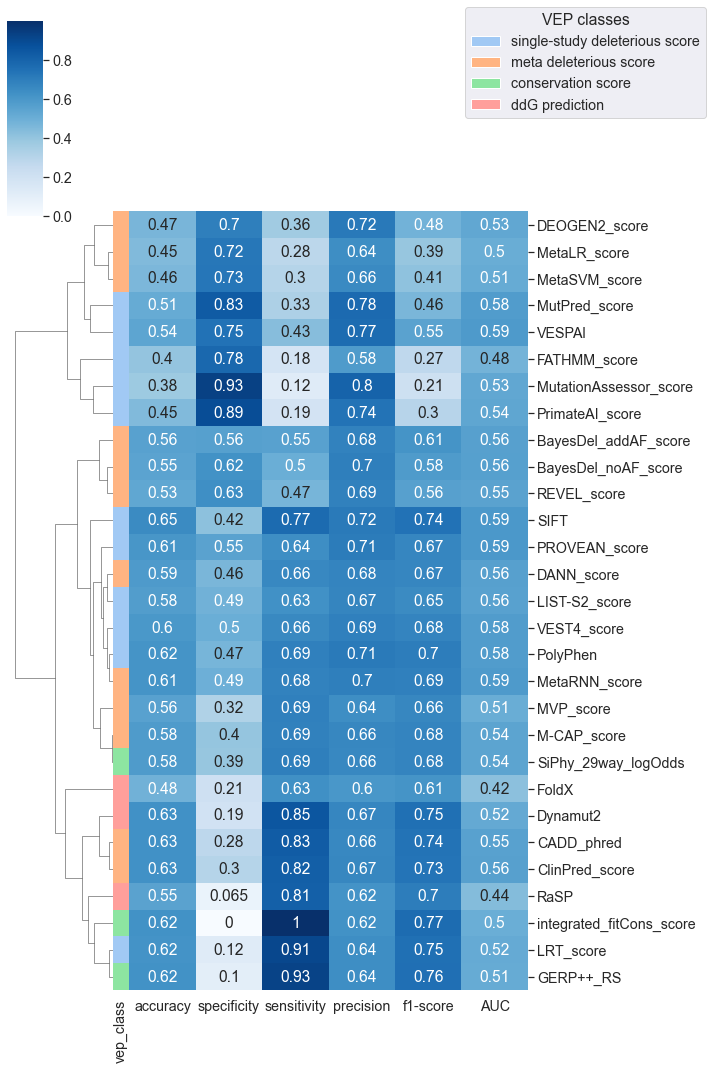

In [704]:
sns.set(font_scale=1.3)
perf_df = perf_df.rename(index = perf_df['vep'])
# plt.figure(figsize=(8, 10))
lut = dict(zip(perf_df['vep_class'].unique(), sns.color_palette("pastel",4)))
handles = [Patch(facecolor=lut[name]) for name in lut]
row_colors = perf_df['vep_class'].map(lut)
sns.clustermap(perf_df.iloc[:,[1,2,3,4,5,7]], figsize=(10, 15),cmap="Blues",annot=True, col_cluster=False,row_colors=row_colors)
plt.legend(handles, lut, title='VEP classes',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
# ,cbar_kws={'label': 'metrics'}
# plt.savefig('GPCRdb_clustermap_0506.png',bbox_inches='tight')

In [358]:
# perf_df.to_csv('perf_df_NoAgg.csv',index=False)
# perf_df.to_csv('perf_df_Agg_max.csv',index=False)
# perf_df.to_csv('perf_df_Agg_mean30.csv',index=False)

,vep_input,mutation_pos,SYMBOL,Amino_acids,protein,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,...,exp_mu_effect_value,exp_fold_change,exp_mu_effect_qual,exp_mu_effect_ligand_prop,exp_mu_ligand_ref,opt_receptor_expression,opt_basal_activity,opt_gain_of_activity,opt_ligand_emax,opt_agonist
7042,ENST00000395052:p.Arg635Ala,635,GRM2,R/A,grm2_human,deleterious(0),probably_damaging(0.935),-,-,-,...,6.21,-6.623,NaN,NaN,Glutamate,0.0,0.0,NaN,0.0,NaN
7043,ENST00000395052:p.Arg635Ala,635,GRM2,R/A,grm2_human,deleterious(0),probably_damaging(0.935),-,-,-,...,6.07,-1.318,NaN,NaN,Glutamate,0.0,0.0,NaN,0.0,NaN
7044,ENST00000395052:p.Arg635Ala,635,GRM2,R/A,grm2_human,deleterious(0),probably_damaging(0.935),-,-,-,...,6.42,-3.021,NaN,NaN,Glutamate,0.0,0.0,NaN,0.0,NaN
7045,ENST00000395052:p.Leu639Ala,639,GRM2,L/A,grm2_human,deleterious(0),probably_damaging(0.991),-,-,-,...,5.86,-14.706,NaN,NaN,Glutamate,0.0,0.0,NaN,0.0,NaN
7046,ENST00000395052:p.Leu639Ala,639,GRM2,L/A,grm2_human,deleterious(0),probably_damaging(0.991),-,-,-,...,5.83,-2.288,NaN,NaN,Glutamate,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7407,ENST00000639785:p.Ala844Val,844,CASR,A/V,casr_human,deleterious(0),benign(0.066),0.192839,0.0392231,25.8,...,7.59,8.128,NaN,NaN,Ca2+,0.0,0.0,NaN,0.0,NaN
7408,ENST00000639785:p.Leu848Ala,848,CASR,L/A,casr_human,deleterious(0),possibly_damaging(0.854),-,-,-,...,6.22,-1.318,NaN,NaN,Ca2+,109.0,0.0,NaN,0.0,NaN
7410,ENST00000639785:p.Leu848Ala,848,CASR,L/A,casr_human,deleterious(0),possibly_damaging(0.854),-,-,-,...,6.62,2.239,NaN,NaN,Ca2+,0.0,0.0,NaN,0.0,NaN
7411,ENST00000639785:p.Leu848Ala,848,CASR,L/A,casr_human,deleterious(0),possibly_damaging(0.854),-,-,-,...,6.66,1.380,NaN,NaN,Ca2+,0.0,0.0,NaN,0.0,NaN


In [466]:
VEPwithGPCR['class'] = VEPwithGPCR['exp_fold_change'].apply(lambda x: 1 if x < -5 else (1 if x > 5 else 0))
VEPwithGPCR['class'].value_counts()

0    6940
1    2800
Name: class, dtype: int64

### 0-1 distribution-vep score

In [ ]:

sns.set(style="white")
for i in range(len(VEP_list)):
    vep = sthresh['VEP'][i]
    temp1 = VEPwithGPCR[VEPwithGPCR[vep]!='-'][['SYMBOL', 'mutation_pos','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
    temp1['class'] = temp1['exp_fold_change'].apply(lambda x: 'affect binding/potency' if x < -2 else ('affect binding/potency' if x > 2 else 'no/low effect'))
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
        temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1[vep] = temp2
        temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
    temp1[vep] = temp1[vep].astype(float)
    plt.figure(figsize=(8, 8))
    sns.displot(data=temp1, x=vep, hue="class", kind="kde", palette="Set1")
    plt.savefig(f'distribution_vepscores_2groups/{vep}.png')
    # ax = sns.boxplot(data=temp1, x=vep, y="class")
    plt.show()


### VEP score distribution: different foldchange threshold

In [648]:
VEPwithGPCR['exp_fold_change'].max()

2511886432.0

have effect      1274
no/low effect      19
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

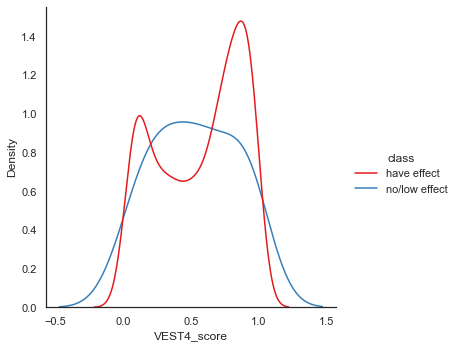

have effect      814
no/low effect    479
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

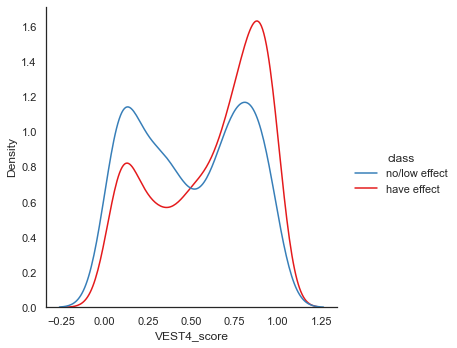

no/low effect    651
have effect      642
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

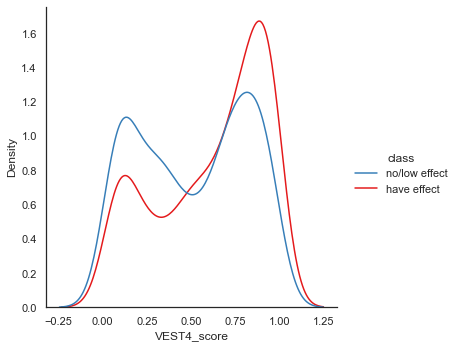

no/low effect    824
have effect      469
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

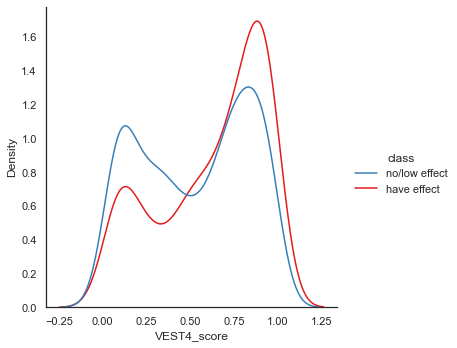

no/low effect    905
have effect      388
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

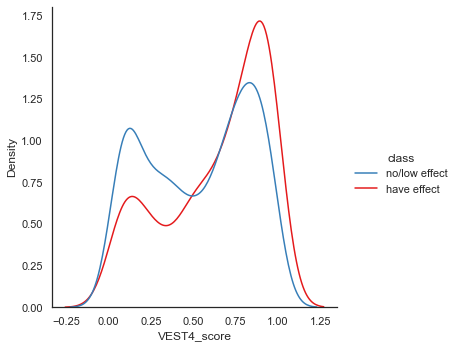

no/low effect    978
have effect      315
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

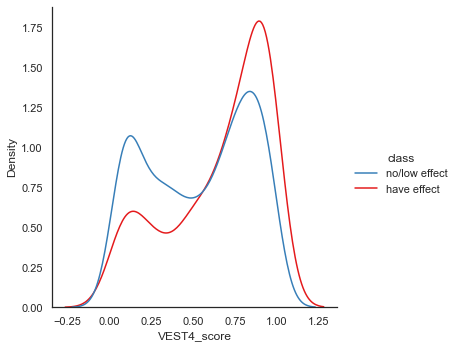

In [660]:
sns.set_style("white")
for fc in [1,2,3,5,7,10]:
    vep = 'VEST4_score'
    temp1 = VEPwithGPCR[VEPwithGPCR[vep]!='-'][['SYMBOL', 'mutation_pos','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
    temp1['abs_foldchange'] = np.abs(temp1['exp_fold_change'])
    # temp1['class'] = temp1['exp_fold_change'].apply(lambda x: 'have effect' if x < -fc else ('have effect' if x > fc else 'no/low effect'))
    # print(temp1['class'].value_counts())
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
        temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1[vep] = temp2
        temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
    temp1[vep] = temp1[vep].astype(float)

    # aggregation == 'max'
    ag_temp = temp1.groupby(by=["SYMBOL","mutation_pos","Amino_acids"])[[vep,'abs_foldchange']].max()
    ag_temp['class'] = ag_temp['abs_foldchange'].apply(lambda x: 'have effect' if x > fc else 'no/low effect')
    print(ag_temp['class'].value_counts())
    my_pal = {"have effect": sns.color_palette("Set1")[0], "no/low effect": sns.color_palette("Set1")[1]}


    plt.figure(figsize=(10, 10))
    # fig, ax = plt.subplots(figsize=(10, 6))
    sns.displot(data=ag_temp, x=vep, common_norm=False, kind="kde", hue="class", palette=my_pal)
    # displaying the title
    # plt.title(f'Foldchange threshold: +/-{fc}')
    # plt.tight_layout()
    plt.savefig(f'distribution_vepscores_2groups/{vep}_fc{fc}.png')
    # ax = sns.boxplot(data=temp1, x=vep, y="class")
    plt.show()



### Classification performance: different foldchange threshold

In [496]:
perf_dm_fc_all = pd.DataFrame()
fc_list=[1,2,3,4,5,6,7,8,9,10]
for i in range(len(fc_list)):
    perf_df_dm = get_performance(VEPwithGPCR,'max',fc_list[i],general=True)
    perf_df_dm['foldchange']=fc_list[i]
    perf_dyna = get_performance_other(Dynamut2withGPCR,'Dynamut2','max',fc_list[i],general=True)
    perf_dyna['foldchange']=fc_list[i]
    perf_ves = get_performance_other(VESPAwithGPCR,'VESPAl','max',fc_list[i],general=True)
    perf_ves['foldchange']=fc_list[i]
    perf_fx = get_performance_other(FoldXwithGPCR,'FoldX','max',fc_list[i],general=True)
    perf_fx['foldchange']=fc_list[i]
    perf_rp = get_performance_other(RASPwithGPCR,'RaSP','max',fc_list[i],general=True)
    perf_rp['foldchange']=fc_list[i]
    perf_dm_fc_all = pd.concat([perf_dm_fc_all,perf_df_dm,perf_dyna,perf_ves,perf_fx,perf_rp],ignore_index=True)




start:  max
processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing VEP:  DEOGEN2_score
processing VEP:  FATHMM_score
processing VEP:  integrated_fitCons_score
processing VEP:  LIST-S2_score
processing VEP:  LRT_score
processing VEP:  M-CAP_score
processing VEP:  MVP_score
processing VEP:  MetaLR_score
processing VEP:  MetaRNN_score
processing VEP:  MetaSVM_score
processing VEP:  MutationAssessor_score
processing VEP:  PROVEAN_score
processing VEP:  PrimateAI_score
processing VEP:  REVEL_score
processing VEP:  VEST4_score
processing VEP:  GERP++_RS
processing VEP:  SiPhy_29way_logOdds
processing VEP:  MutPred_score
start:  max
processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP: 

In [497]:
perf_dm_fc_all

,vep,accuracy,precision,f1-score,mcc,specificity,sensitivity,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,foldchange
0,SIFT,0.707189,0.991429,0.827175,0.055137,0.516129,0.709611,0.612870,1735/15,16/710,31,2445,726,1750,1
1,PolyPhen,0.633279,0.987937,0.774129,0.005431,0.387097,0.636401,0.511749,1556/19,12/889,31,2445,901,1575,1
2,BayesDel_addAF_score,0.514308,0.986446,0.675955,0.009737,0.526316,0.514129,0.520222,655/9,10/619,19,1274,629,664,1
3,BayesDel_noAF_score,0.460170,0.986486,0.625938,0.009020,0.578947,0.458399,0.518673,584/8,11/690,19,1274,701,592,1
4,CADD_phred,0.783449,0.986301,0.878049,0.016073,0.263158,0.791209,0.527183,1008/14,5/266,19,1274,271,1022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,MutPred_score,0.681891,0.368732,0.386399,0.172714,0.772340,0.405844,0.589092,125/214,726/183,940,308,909,339,10
286,Dynamut2,0.372636,0.295137,0.440215,0.051125,0.176140,0.865819,0.520979,613/1464,313/95,1777,708,408,2077,10
287,VESPAl,0.615292,0.365801,0.414216,0.137881,0.670231,0.477401,0.573816,338/586,1191/370,1777,708,1561,924,10
288,FoldX,0.360258,0.240850,0.340000,-0.144376,0.273446,0.577904,0.425675,408/1286,484/298,1770,706,782,1694,10


In [629]:
# import the names of VEPs
VEP_list_sub = [
# "SIFT",
"PolyPhen",
# "BayesDel_addAF_score",
# "BayesDel_noAF_score",
"CADD_phred",
# "ClinPred_score",
"DANN_score",
# "DEOGEN2_score",
"FATHMM_score",
# "integrated_fitCons_score",
# "LIST-S2_score",
# "LRT_score",
# "M-CAP_score",
# "MVP_score",
# "MetaLR_score",
# "MetaRNN_score",
# "MetaSVM_score",
# "MutationAssessor_score",
# "PROVEAN_score",
# "PrimateAI_score",
# "REVEL_score",
# "VEST4_score",
"GERP++_RS",
# "SiPhy_29way_logOdds",
"MutPred_score"
]



In [666]:
perf_dm_fc_all

,vep,accuracy,precision,f1-score,mcc,specificity,sensitivity,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,foldchange
0,SIFT,0.707189,0.991429,0.827175,0.055137,0.516129,0.709611,0.612870,1735/15,16/710,31,2445,726,1750,1
1,PolyPhen,0.633279,0.987937,0.774129,0.005431,0.387097,0.636401,0.511749,1556/19,12/889,31,2445,901,1575,1
2,BayesDel_addAF_score,0.514308,0.986446,0.675955,0.009737,0.526316,0.514129,0.520222,655/9,10/619,19,1274,629,664,1
3,BayesDel_noAF_score,0.460170,0.986486,0.625938,0.009020,0.578947,0.458399,0.518673,584/8,11/690,19,1274,701,592,1
4,CADD_phred,0.783449,0.986301,0.878049,0.016073,0.263158,0.791209,0.527183,1008/14,5/266,19,1274,271,1022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,MutPred_score,0.681891,0.368732,0.386399,0.172714,0.772340,0.405844,0.589092,125/214,726/183,940,308,909,339,10
286,Dynamut2,0.372636,0.295137,0.440215,0.051125,0.176140,0.865819,0.520979,613/1464,313/95,1777,708,408,2077,10
287,VESPAl,0.615292,0.365801,0.414216,0.137881,0.670231,0.477401,0.573816,338/586,1191/370,1777,708,1561,924,10
288,FoldX,0.360258,0.240850,0.340000,-0.144376,0.273446,0.577904,0.425675,408/1286,484/298,1770,706,782,1694,10


/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1137424722.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1137424722.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)


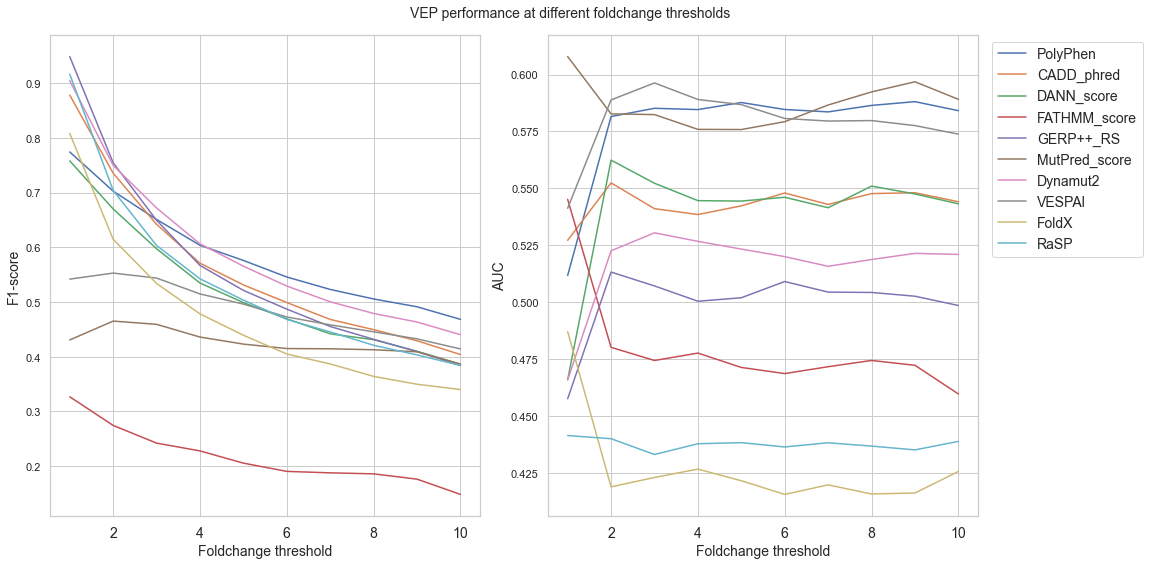

In [691]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=perf_dm_fc_all[perf_dm_fc_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='foldchange', y='f1-score', hue='vep',err_style="bars",ax=axes[0])
# Rotate x-axis labels on ax1
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
# Remove x-label
axes[0].set_xlabel('Foldchange threshold',fontsize=14)
axes[0].set_ylabel('F1-score',fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)

axes[0].legend('', frameon=False)

# Plot the second lineplot on the second subplot
sns.lineplot(data=perf_dm_fc_all[perf_dm_fc_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='foldchange', y='AUC', hue='vep',err_style="bars",ax=axes[1])
# axes[1].set_xlim(0,0.1)
# Rotate x-axis labels on ax1
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
# Remove x-label
axes[1].set_xlabel('Foldchange threshold',fontsize=14)
axes[1].set_ylabel('AUC',fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)

plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance at different foldchange thresholds',fontsize=14)
plt.tight_layout()
# Show the plot
plt.savefig('/Users/joannahench/Documents/UCPH/MSc_Thesis/thesis_figures/gpcrdb_thresh_fc_f1_auc.png')
plt.show()

### Subsets, different ligand classes - for each vep, calculate for 69 GPCRs with error bar

In [382]:
VEPwithGPCR['ligand_class'] = VEPwithGPCR['ligand_class'].fillna('NaN')
Dynamut2withGPCR['ligand_class'] = Dynamut2withGPCR['ligand_class'].fillna('NaN')
VESPAwithGPCR['ligand_class'] = VESPAwithGPCR['ligand_class'].fillna('NaN')
FoldXwithGPCR['ligand_class'] = FoldXwithGPCR['ligand_class'].fillna('NaN')

In [509]:
# import the names of VEPs
VEP_list_sub = [
# "SIFT",
"PolyPhen",
# "BayesDel_addAF_score",
# "BayesDel_noAF_score",
"CADD_phred",
# "ClinPred_score",
"DANN_score",
# "DEOGEN2_score",
"FATHMM_score",
# "integrated_fitCons_score",
# "LIST-S2_score",
# "LRT_score",
# "M-CAP_score",
# "MVP_score",
# "MetaLR_score",
# "MetaRNN_score",
# "MetaSVM_score",
# "MutationAssessor_score",
# "PROVEAN_score",
# "PrimateAI_score",
# "REVEL_score",
# "VEST4_score",
"GERP++_RS",
# "SiPhy_29way_logOdds",
"MutPred_score"
]



In [178]:
prot_list = np.unique(VEPwithGPCR['protein'].tolist())
prot_list

array(['5ht1a_human', '5ht1b_human', '5ht1d_human', '5ht2a_human',
       '5ht2b_human', '5ht2c_human', '5ht4r_human', '5ht5a_human',
       '5ht6r_human', '5ht7r_human', 'aa1r_human', 'aa2ar_human',
       'aa2br_human', 'aa3r_human', 'acm1_human', 'acm2_human',
       'acm3_human', 'acm4_human', 'acm5_human', 'ada1a_human',
       'ada1b_human', 'ada2b_human', 'adrb1_human', 'adrb2_human',
       'adrb3_human', 'calrl_human', 'casr_human', 'ccr1_human',
       'ccr2_human', 'ccr3_human', 'ccr5_human', 'ccr8_human',
       'cnr2_human', 'crfr1_human', 'cxcr1_human', 'cxcr2_human',
       'cxcr3_human', 'cxcr4_human', 'drd1_human', 'drd2_human',
       'drd3_human', 'drd5_human', 'ednrb_human', 'fshr_human',
       'ghrhr_human', 'gipr_human', 'glp1r_human', 'glr_human',
       'grm1_human', 'grm2_human', 'grm5_human', 'hrh1_human',
       'hrh2_human', 'hrh3_human', 'hrh4_human', 'lshr_human',
       'mc4r_human', 'p2ry2_human', 'p2y12_human', 'pth1r_human',
       'pth2r_human', 'sct

use ligand class

In [ ]:
# single_gpcr_res = pd.DataFrame()
# for prot in prot_list:
#     ligands = np.unique(VEPwithGPCR[VEPwithGPCR['protein']==prot]['ligand_class'].tolist())
#     for i in range(len(ligands)):
#         temp = VEPwithGPCR[(VEPwithGPCR['protein'] == prot) & (VEPwithGPCR['ligand_class'] == ligands[i])]
#         temp_out = get_performance_subsets(temp,'max')
#         temp_out['ligand_class']=ligands[i]
#         single_gpcr_res = pd.concat([single_gpcr_res, temp_out], ignore_index=True)


use merged new ligand types

In [273]:
np.unique(VEPwithGPCR['ligand type'])

array(['Agonist', 'Antagonist', 'Inverse agonist', 'Unknown'],
      dtype=object)

In [661]:
Agonist_list = ['Agonist','Full agonist','Allosteric agonist','Positive allosteric modulator','Partial agonist']
Antagonist_list = ['Antagonist','Antagonist (neutral/silent)','Negative allosteric modulator - noncompetitive antagonist']
Unknown_list = ['Binding - unknown pharmacological activity','NaN']
Inverse_agonist = ['Inverse agonist','Allosteric inverse agonist']

merge_class = {'Agonist': Agonist_list, 'Antagonist':Antagonist_list,'Binding':Unknown_list,'Inverse agonist':Inverse_agonist}
# create a function to map classes to new_classes
def map_classes(x):
    for key, value in merge_class.items():
        if x in value:
            return key
    return 'other'

# add new column to dataframe
VEPwithGPCR['ligand type'] = VEPwithGPCR['ligand_class'].apply(map_classes)
Dynamut2withGPCR['ligand type'] = Dynamut2withGPCR['ligand_class'].apply(map_classes)
VESPAwithGPCR['ligand type'] = VESPAwithGPCR['ligand_class'].apply(map_classes)
FoldXwithGPCR['ligand type'] = FoldXwithGPCR['ligand_class'].apply(map_classes)
RASPwithGPCR['ligand type'] = RASPwithGPCR['ligand_class'].apply(map_classes)
RASPwithGPCR=RASPwithGPCR[RASPwithGPCR['ligand type']!='other']


/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1936111136.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RASPwithGPCR['ligand type'] = RASPwithGPCR['ligand_class'].apply(map_classes)


In [695]:
def vep_sub_perf(df,subset):
    all_gpcr_res = pd.DataFrame()
    if subset=='ligand':
        for prot in prot_list:
            ligands = np.unique(df[df['protein']==prot]['ligand type'].tolist())
            for i in range(len(ligands)):
                temp = df[(df['protein'] == prot) & (df['ligand type'] == ligands[i])]
                temp_out = get_performance(temp,'max',2,general=False)
                temp_out['ligand type']=ligands[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res
    elif subset=='function':
        for prot in prot_list:
            func = np.unique(df[df['protein']==prot]['functional_site'].tolist())
            for i in range(len(func)):
                temp = df[(df['protein'] == prot) & (df['functional_site'] == func[i])]
                temp_out = get_performance(temp,'max',2,general=False)
                temp_out['functional_site']=func[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res

def vep_sub_perf_other(df,type,subset):
    all_gpcr_res = pd.DataFrame()
    if subset=='ligand':
        for prot in prot_list:
            ligands = np.unique(df[df['protein']==prot]['ligand type'].tolist())
            for i in range(len(ligands)):
                temp = df[(df['protein'] == prot) & (df['ligand type'] == ligands[i])]
                temp_out = get_performance_other(temp,type,'max',2,general=False)
                temp_out['ligand type']=ligands[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res
    elif subset=='function':
        for prot in prot_list:
            func = np.unique(df[df['protein']==prot]['functional_site'].tolist())
            for i in range(len(func)):
                temp = df[(df['protein'] == prot) & (df['functional_site'] == func[i])]
                temp_out = get_performance_other(temp,type,'max',2,general=False)
                temp_out['functional_site']=func[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res


In [ ]:

ensemble_gpcr_res = vep_sub_perf(VEPwithGPCR,'ligand')
dyna_gpcr_res = vep_sub_perf_other(Dynamut2withGPCR,'Dynamut2','ligand')
ves_gpcr_res = vep_sub_perf_other(VESPAwithGPCR,'VESPAl','ligand')
fdx_gpcr_res = vep_sub_perf_other(FoldXwithGPCR,'FoldX','ligand')
rasp_gpcr_res = vep_sub_perf_other(RASPwithGPCR,'RaSP','ligand')

In [663]:
sub_perf_df = pd.concat([ensemble_gpcr_res,dyna_gpcr_res,ves_gpcr_res,fdx_gpcr_res,rasp_gpcr_res]).reset_index()
sub_perf_df = sub_perf_df.drop(columns=['index'])
sub_perf_df = sub_perf_df[sub_perf_df['ligand type']!='other']
sub_perf_df

,vep,accuracy,precision,f1-score,mcc,ligand type
0,SIFT,0.727273,0.875000,0.823529,0.240563,Binding
1,PolyPhen,0.727273,0.800000,0.842105,-0.149071,Binding
2,BayesDel_addAF_score,0.500000,0.750000,0.600000,0.000000,Binding
3,BayesDel_noAF_score,0.500000,0.750000,0.600000,0.000000,Binding
4,CADD_phred,0.750000,0.750000,0.857143,0.000000,Binding
...,...,...,...,...,...,...
3073,RaSP,0.377729,0.383693,0.528926,-0.173664,Agonist
3074,RaSP,0.545455,0.600000,0.705882,-0.239046,Agonist
3075,RaSP,0.458333,0.428571,0.580645,0.063888,Binding
3076,RaSP,1.000000,1.000000,1.000000,0.000000,Agonist


In [664]:
res1 = sub_perf_df[sub_perf_df['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])]
# take average
res2 = pd.DataFrame(res1.groupby(by=["vep","ligand type"]).mean())



/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1994960632.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)


ValueError: Could not interpret value `AUC` for parameter `y`

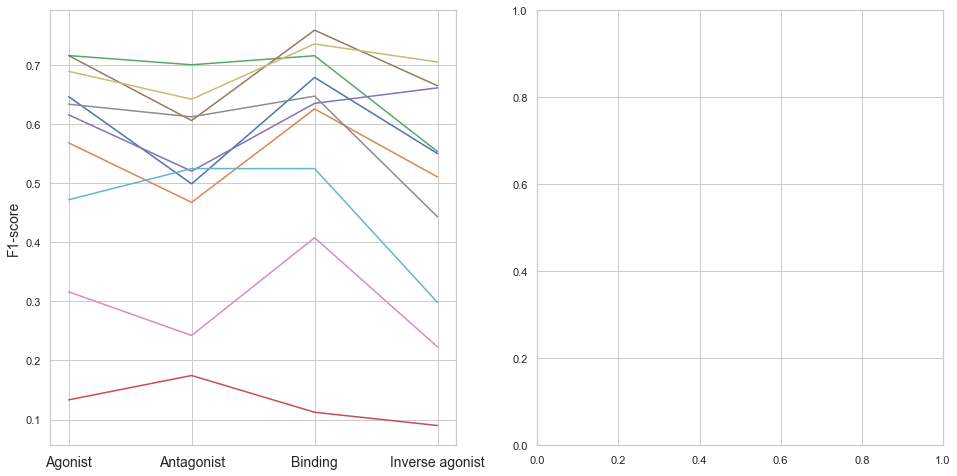

In [692]:
sns.set(style="whitegrid")
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=res2, x='ligand type', y='f1-score', hue='vep',err_style="bars",ax=axes[0])
axes[0].set_xlabel(None)
axes[0].set_ylabel('F1-score',fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)

axes[0].legend('', frameon=False)
# Plot the second lineplot on the second subplot
sns.lineplot(data=res2, x='ligand type', y='AUC', hue='vep',err_style="bars",ax=axes[1])
# Rotate x-axis labels on ax1
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
# Remove x-label
axes[1].set_xlabel(None)
axes[1].set_ylabel('Accuracy',fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance on subsets - ligand types',fontsize=14)

# Show the plot
plt.show()

### Subsets, different functional annotations

In [379]:
anno_df = pd.read_csv('processed_func_anno.csv')
anno_df

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,protein,Family,mutation_from,mutation_pos,func_anno,func_anno_status
0,5ht1a_human,5-Hydroxytryptamine receptors,T,196,PTMsite,yes
1,5ht1a_human,5-Hydroxytryptamine receptors,S,199,PTMsite,yes
2,5ht1a_human,5-Hydroxytryptamine receptors,Y,205,PTMsite,yes
3,5ht1a_human,5-Hydroxytryptamine receptors,Y,215,PTMsite,yes
4,5ht1a_human,5-Hydroxytryptamine receptors,T,240,PTMsite,yes
...,...,...,...,...,...,...
209880,gp157_human,Other GPCR orphans,G,330,func_unknown,NaN
209881,gp157_human,Other GPCR orphans,E,331,func_unknown,NaN
209882,gp157_human,Other GPCR orphans,L,332,func_unknown,NaN
209883,gp157_human,Other GPCR orphans,P,333,func_unknown,NaN


In [522]:
VEPwithGPCR

,protein,Family,mutation_from,mutation_pos,func_anno,func_anno_status
0,5ht1a_human,5-Hydroxytryptamine receptors,T,196,PTMsite,yes
1,5ht1a_human,5-Hydroxytryptamine receptors,S,199,PTMsite,yes
2,5ht1a_human,5-Hydroxytryptamine receptors,Y,205,PTMsite,yes
3,5ht1a_human,5-Hydroxytryptamine receptors,Y,215,PTMsite,yes
4,5ht1a_human,5-Hydroxytryptamine receptors,T,240,PTMsite,yes
...,...,...,...,...,...,...
209880,gp157_human,Other GPCR orphans,G,330,func_unknown,NaN
209881,gp157_human,Other GPCR orphans,E,331,func_unknown,NaN
209882,gp157_human,Other GPCR orphans,L,332,func_unknown,NaN
209883,gp157_human,Other GPCR orphans,P,333,func_unknown,NaN


In [524]:
VEPwithGPCR_anno = pd.merge(VEPwithGPCR,anno_df[['protein','mutation_pos','func_anno']],on=['protein','mutation_pos'])
Dynamut2withGPCR_anno = pd.merge(Dynamut2withGPCR,anno_df[['protein','mutation_pos','func_anno']],on=['protein','mutation_pos'])
VESPAwithGPCR_anno = pd.merge(VESPAwithGPCR,anno_df[['protein','mutation_pos','func_anno']],on=['protein','mutation_pos'])
FoldXwithGPCR_anno = pd.merge(FoldXwithGPCR,anno_df[['protein','mutation_pos','func_anno']],on=['protein','mutation_pos'])
RASPwithGPCR_anno = pd.merge(RASPwithGPCR,anno_df[['protein','mutation_pos','func_anno']],on=['protein','mutation_pos'])


In [531]:
func_unknown = ['func_unknown']
LB_structure_human = ['LB_structure_human']
LB_fam = ['LB_fam']
Other_func = ['ActivationPathway','MicroSwitch','PTMsite','SodiumPocket']
Gprotein_interface = ['GProteinInteraction']


merge_class = {'func_unknown': func_unknown, 'LB_structure_human':LB_structure_human,'LB_fam':LB_fam,'Other_func':Other_func,'Gprotein_interface':Gprotein_interface}

# create a function to map classes to new_classes
def map_classes(x):
    for key, value in merge_class.items():
        if x in value:
            return key
    return 'other'

# add new column to dataframe
VEPwithGPCR_anno['functional_site'] = VEPwithGPCR_anno['func_anno'].apply(map_classes)
Dynamut2withGPCR_anno['functional_site'] = Dynamut2withGPCR_anno['func_anno'].apply(map_classes)
VESPAwithGPCR_anno['functional_site'] = VESPAwithGPCR_anno['func_anno'].apply(map_classes)
FoldXwithGPCR_anno['functional_site'] = FoldXwithGPCR_anno['func_anno'].apply(map_classes)
RASPwithGPCR_anno['functional_site'] = RASPwithGPCR_anno['func_anno'].apply(map_classes)

In [ ]:

ensemble_with_anno_perf = vep_sub_perf(VEPwithGPCR_anno,'function')
dyna_with_anno_perf = vep_sub_perf_other(Dynamut2withGPCR_anno,'Dynamut2','function')
ves_with_anno_perf = vep_sub_perf_other(VESPAwithGPCR_anno,'VESPAl','function')
fdx_with_anno_perf = vep_sub_perf_other(FoldXwithGPCR_anno,'FoldX','function')
rasp_with_anno_perf = vep_sub_perf_other(RASPwithGPCR_anno,'RaSP','function')

In [533]:
sub_anno_perf_df = pd.concat([ensemble_with_anno_perf,dyna_with_anno_perf,ves_with_anno_perf,fdx_with_anno_perf,rasp_with_anno_perf]).reset_index()
sub_anno_perf_df = sub_anno_perf_df.drop(columns=['index'])
sub_anno_perf_df

,vep,accuracy,precision,f1-score,mcc,functional_site
0,SIFT,0.666667,1.000000,0.800000,0.000000,LB_fam
1,PolyPhen,1.000000,1.000000,1.000000,0.000000,LB_fam
2,BayesDel_addAF_score,0.000000,0.000000,0.000000,0.000000,LB_fam
3,BayesDel_noAF_score,0.000000,0.000000,0.000000,0.000000,LB_fam
4,CADD_phred,1.000000,1.000000,1.000000,0.000000,LB_fam
...,...,...,...,...,...,...
5919,RaSP,0.500000,0.666667,0.666667,-0.333333,LB_structure_human
5920,RaSP,0.666667,0.666667,0.800000,0.000000,Other_func
5921,RaSP,0.437500,0.413793,0.571429,0.047752,func_unknown
5922,RaSP,1.000000,1.000000,1.000000,0.000000,LB_fam


In [639]:
res3 = sub_anno_perf_df[sub_anno_perf_df['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])]
# take average
res4 = pd.DataFrame(res3.groupby(by=["vep","functional_site"]).mean())



/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1554671200.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90,fontsize=14)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/1554671200.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90,fontsize=14)


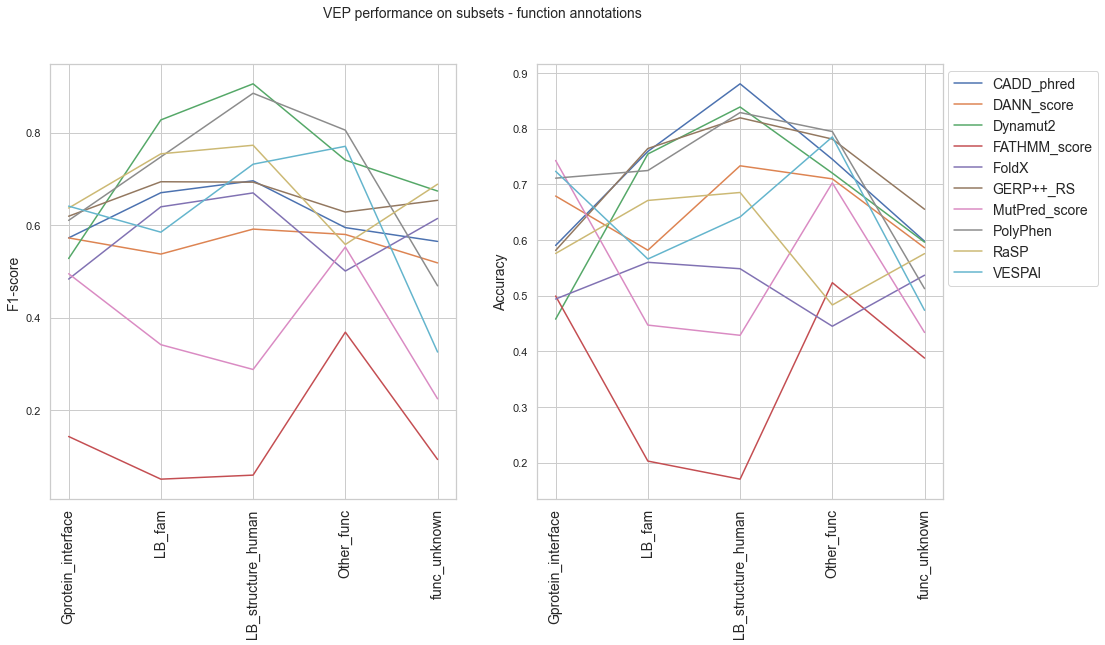

In [679]:
sns.set(style="whitegrid")
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=res4, x='functional_site', y='f1-score', hue='vep',err_style="bars",ax=axes[0])
# Rotate x-axis labels on ax1
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90,fontsize=14)
# Remove x-label
axes[0].set_xlabel(None)
axes[0].set_ylabel('F1-score',fontsize=14)

axes[0].legend('', frameon=False)

# Plot the second lineplot on the second subplot
sns.lineplot(data=res4, x='functional_site', y='accuracy', hue='vep',err_style="bars",ax=axes[1])
# Rotate x-axis labels on ax1
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90,fontsize=14)
# Remove x-label
axes[1].set_xlabel(None)
axes[1].set_ylabel('Accuracy',fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance on subsets - function annotations',fontsize=14)

# Show the plot
plt.show()

# previous

### Subsets, different ligand classes - general, no error bars

In [44]:
VEPwithGPCR['ligand_class'] = VEPwithGPCR['ligand_class'].fillna('NaN')
Dynamut2withGPCR['ligand_class'] = Dynamut2withGPCR['ligand_class'].fillna('NaN')
VESPAwithGPCR['ligand_class'] = VESPAwithGPCR['ligand_class'].fillna('NaN')
FoldXwithGPCR['ligand_class'] = FoldXwithGPCR['ligand_class'].fillna('NaN')
# class_list = np.unique(VEPwithGPCR['ligand_class'].tolist())


In [170]:
Agonist_list = ['Agonist','Full agonist','Allosteric agonist','Positive allosteric modulator']
Antagonist_list = ['Antagonist','Antagonist (neutral/silent)','Negative allosteric modulator - noncompetitive antagonist']
Binding_list = ['Binding - unknown pharmacological activity']
Inverse_agonist = ['Inverse agonist','Allosteric inverse agonist']
Negative = ['Negative allosteric modulator - noncompetitive antagonist']
Positive = ['Positive allosteric modulator']
class_list=[Agonist_list,Antagonist_list,Binding_list,Inverse_agonist]
class_name = ['Agonist-related','Antagonist-related','Binding','Inverse agonist']



In [52]:
# import the names of VEPs
VEP_list_sub = [
# "SIFT",
# "PolyPhen",
# "BayesDel_addAF_score",
# "BayesDel_noAF_score",
# "CADD_phred",
"ClinPred_score",
# "DANN_score",
# "DEOGEN2_score",
"FATHMM_score",
# "integrated_fitCons_score",
# "LIST-S2_score",
# "LRT_score",
"M-CAP_score",
# "MVP_score",
# "MetaLR_score",
"MetaRNN_score",
# "MetaSVM_score",
# "MutationAssessor_score",
# "PROVEAN_score",
# "PrimateAI_score",
"REVEL_score",
# "VEST4_score",
"GERP++_RS",
# "SiPhy_29way_logOdds",
# "MutPred_score"
]


In [ ]:
f1_df = pd.DataFrame()
auc_df = pd.DataFrame()
row = 0
for i in range(len(class_list)):
    # Ensembl VEP
    subset_icd = VEPwithGPCR[VEPwithGPCR['ligand_class'].isin(class_list[i])]
    perf_df_subset = get_performance(subset_icd,'max')
    f1_df.loc[row,'ligand_class'] = class_name[i]
    auc_df.loc[row,'ligand_class'] = class_name[i]
    for vep in VEP_list_sub:
        f1_df.loc[row,vep] = perf_df_subset[perf_df_subset['vep']==vep].iloc[0,5] 
        auc_df.loc[row,vep] = perf_df_subset[perf_df_subset['vep']==vep].iloc[0,7]
    
    #Dynamut2 and VESPAl
    dyna_sub = Dynamut2withGPCR[Dynamut2withGPCR['ligand_class'].isin(class_list[i])]
    ves_sub = VESPAwithGPCR[VESPAwithGPCR['ligand_class'].isin(class_list[i])]
    foldx_sub = FoldXwithGPCR[FoldXwithGPCR['ligand_class'].isin(class_list[i])]

    perf_df_dyna = get_performance_other(dyna_sub,'Dynamut2','max')
    perf_df_ves = get_performance_other(ves_sub,'VESPAl','max')
    perf_df_foldx = get_performance_other(foldx_sub,'FoldX','max')

    f1_df.loc[row,'Dynamut2'] = perf_df_dyna.iloc[0,5] 
    auc_df.loc[row,'Dynamut2'] = perf_df_dyna.iloc[0,7]

    f1_df.loc[row,'VESPAl'] = perf_df_ves.iloc[0,5] 
    auc_df.loc[row,'VESPAl'] = perf_df_ves.iloc[0,7]  

    f1_df.loc[row,'FoldX'] = perf_df_foldx.iloc[0,5] 
    auc_df.loc[row,'FoldX'] = perf_df_foldx.iloc[0,7]      
    
    row += 1


In [54]:
f1_df

,ligand_class,ClinPred_score,FATHMM_score,M-CAP_score,MetaRNN_score,REVEL_score,GERP++_RS,Dynamut2,VESPAl,FoldX
0,Agonist-related,0.687559,0.281457,0.631139,0.646355,0.532650,0.704876,0.702828,0.503892,0.320000
1,Antagonist-related,0.652174,0.025641,0.575758,0.483333,0.236559,0.728395,0.781327,0.519084,0.378601
2,Binding,0.767773,0.123457,0.661682,0.720143,0.547461,0.793201,0.791304,0.587269,0.384528
3,Inverse agonist,0.739496,0.148148,0.666667,0.759259,0.611765,0.724409,0.623377,0.489510,0.402985
4,Negative allosteric modulator - noncompetitive...,0.650000,0.698795,0.750000,0.702703,0.666667,0.666667,0.739726,0.666667,0.376471
5,Positive allosteric modulator,0.700000,0.761905,0.761905,0.684211,0.684211,0.761905,0.708861,0.615385,0.304348


In [55]:

# Melt the dataframe to "long" format
f1_melted = pd.melt(f1_df, id_vars=['ligand_class'], value_vars=VEP_list_sub+['Dynamut2','VESPAl','FoldX'],
                    var_name='VEP Tool', value_name='F1-Score')

auc_melted = pd.melt(auc_df, id_vars=['ligand_class'], value_vars=VEP_list_sub+['Dynamut2','VESPAl','FoldX'],
                    var_name='VEP Tool', value_name='AUC-Score')



/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/412392224.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_93331/412392224.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


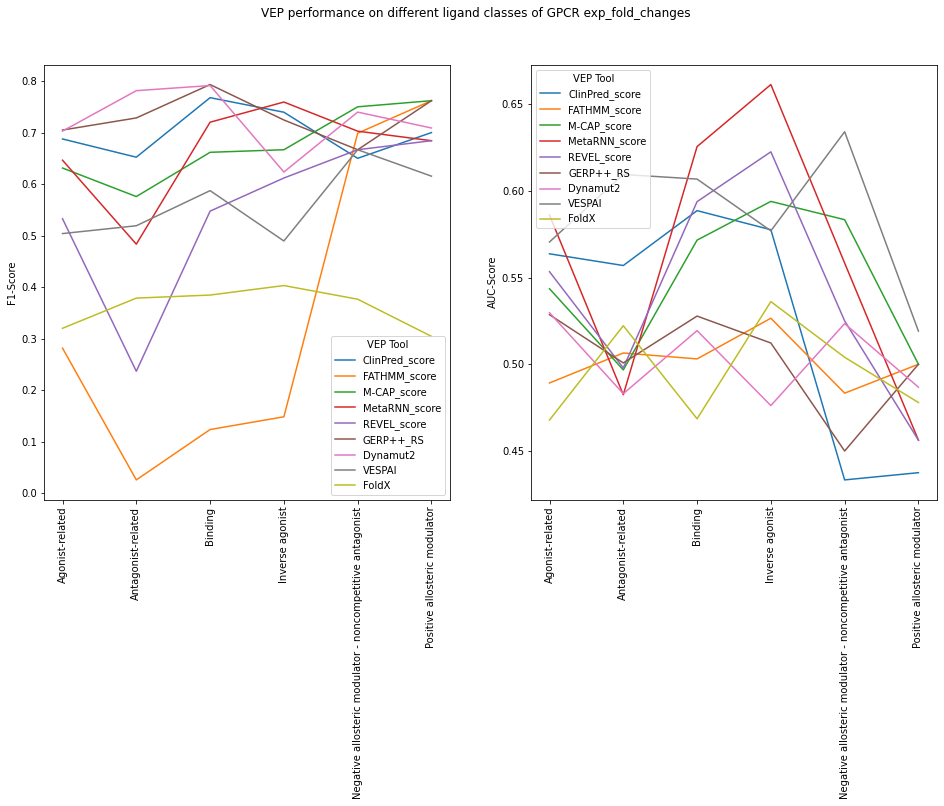

In [56]:
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot
sns.lineplot(x='ligand_class', y='F1-Score', hue='VEP Tool', data=f1_melted, ax=axes[0])
# Rotate x-axis labels on ax1
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
# Remove x-label
axes[0].set_xlabel(None)

# Plot the second lineplot on the second subplot
sns.lineplot(x='ligand_class', y='AUC-Score', hue='VEP Tool', data=auc_melted, ax=axes[1])
# Rotate x-axis labels on ax1
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
# Remove x-label
axes[1].set_xlabel(None)
# Set the common y-axis label
fig.suptitle('VEP performance on different ligand classes of GPCR exp_fold_changes')


# Show the plot
plt.show()

### GPCRdb - subsets: binding and functional

In [57]:
t_df  = VEPwithGPCR.copy()
t_df['exp_func'] = t_df['exp_func'].fillna('nan')
func_subset = t_df[t_df['exp_func'].str.contains('Functional')]
bind_subset = t_df[t_df['exp_func'].str.contains('Binding|binding')]


In [365]:
def get_metric(VEPwithGPCR,aggregation):
    # whether to do aggregation
    # aggregation = 'mean'
    perf_df = pd.DataFrame()

    row = 0
    for i in range(len(VEP_list)):  
        vep = sthresh['VEP'][i]
        print('processing VEP: ',vep)
        thresh_value = sthresh['threshold'][i]
        thresh_greather = sthresh['greater than'][i]

        temp1 = VEPwithGPCR[VEPwithGPCR[vep]!='-'][['mutation_pos','SYMBOL','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
        p1 = re.compile(r'[(](.*?)[)]', re.S)
        if vep == 'SIFT' or vep == 'PolyPhen':
            temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
        elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
            temp2 = temp1[vep].apply(lambda x: list(set(x.split(',')) - set(['.'])))
            temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
            temp1[vep] = temp2
            temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
        temp1[vep] = temp1[vep].astype(float)
        # exp_labels = []
        # pred_labels = []
        # for j in range(temp1.shape[0]):
        #     if thresh_greather==1:
        #         pred_labels.append(1 if temp1[vep][j] > thresh_value else 0)
        #         # exp_labels.append(1 if temp1['exp_fold_change'][j] < -5 or temp1['exp_fold_change'][j] > 5 else 0)
        #     else:
        #         pred_labels.append(1 if temp1[vep][j] < thresh_value else 0)
        #     exp_labels.append(1 if temp1['exp_fold_change'][j] <= -5 or temp1['exp_fold_change'][j] >= 5 else 0)        
        if thresh_greather==1:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x > thresh_value else 0)
        else:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x < thresh_value else 0)
        

        temp1['foldchange_group'] = temp1['exp_fold_change'].apply(lambda x: 1 if x < -2 else (1 if x > 2 else 0))

        if aggregation == 'mean':
            ag_df = temp1.groupby(by=["SYMBOL","mutation_pos","Amino_acids"]).mean()[['vep_group','foldchange_group']]
            ag_df['ag_fc_group'] = (ag_df['foldchange_group'] >= 0.3).astype(int)
            exp_labels = ag_df['ag_fc_group']
            pred_labels = ag_df['vep_group'].astype(int)
        
        elif aggregation == 'max':
            ag_df = temp1.groupby(by=["SYMBOL","mutation_pos","Amino_acids"]).max()[['vep_group','foldchange_group']]
            exp_labels = ag_df['foldchange_group']
            pred_labels = ag_df['vep_group']   

        else:
            exp_labels = temp1['foldchange_group']
            pred_labels = temp1['vep_group']
            
        

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(exp_labels, pred_labels).ravel()

        # Calculate accuracy
        accuracy = accuracy_score(exp_labels, pred_labels)

        # Calculate specificity and sensitivity
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)


        # Calculate precision, recall and F1-score
        precision = precision_score(exp_labels, pred_labels)
        recall = recall_score(exp_labels, pred_labels)
        f1 = f1_score(exp_labels, pred_labels)

        # calculate FPR and TPR
        fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)

        # calculate AUCROC
        auc_roc = auc(fpr, tpr)

        # calculate Matthews Correlation Coefficient
        mcc = matthews_corrcoef(exp_labels, pred_labels)


        # store in df
        perf_df.loc[row,'vep'] = vep
        perf_df.loc[row,'accuracy'] = accuracy
        perf_df.loc[row,'specificity'] = specificity
        perf_df.loc[row,'sensitivity'] = sensitivity
        perf_df.loc[row,'precision'] = precision
        perf_df.loc[row,'f1-score'] = f1
        perf_df.loc[row,'mcc'] = mcc
        perf_df.loc[row,'AUC'] = auc_roc
        perf_df.loc[row,'#tp/#fp'] = str(tp)+'/'+str(fp)
        perf_df.loc[row,'#tn/#fn'] = str(tn)+'/'+str(fn)

        row = row +1
    return perf_df


In [366]:
perf_df_func = get_metric(func_subset,'max')
perf_df_bind = get_metric(bind_subset,'max')


processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing VEP:  DEOGEN2_score
processing VEP:  FATHMM_score
processing VEP:  integrated_fitCons_score
processing VEP:  LIST-S2_score
processing VEP:  LRT_score
processing VEP:  M-CAP_score
processing VEP:  MVP_score
processing VEP:  MetaLR_score
processing VEP:  MetaRNN_score
processing VEP:  MetaSVM_score
processing VEP:  MutationAssessor_score
processing VEP:  PROVEAN_score
processing VEP:  PrimateAI_score
processing VEP:  REVEL_score
processing VEP:  VEST4_score
processing VEP:  GERP++_RS
processing VEP:  SiPhy_29way_logOdds
processing VEP:  MutPred_score
processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing V

In [376]:

df3 = pd.merge(perf_df_func[['vep','accuracy','f1-score','AUC']], perf_df_bind[['vep','accuracy','f1-score','AUC']],on='vep')
df3 = df3[['vep','accuracy_x', 'accuracy_y', 'f1-score_x', 'f1-score_y', 'AUC_x','AUC_y']]
df3

,vep,accuracy_x,accuracy_y,f1-score_x,f1-score_y,AUC_x,AUC_y
0,SIFT,0.573276,0.573545,0.632880,0.637264,0.567332,0.562034
1,PolyPhen,0.557471,0.555556,0.589333,0.592233,0.555158,0.562860
2,BayesDel_addAF_score,0.550287,0.539683,0.597169,0.576436,0.546286,0.546917
3,BayesDel_noAF_score,0.553161,0.529101,0.573388,0.546381,0.552143,0.547002
4,CADD_phred,0.551724,0.593651,0.675676,0.703704,0.536247,0.538110
5,ClinPred_score,0.550287,0.595767,0.668783,0.701563,0.535862,0.544228
6,DANN_score,0.544540,0.569312,0.625738,0.642669,0.536185,0.550771
7,DEOGEN2_score,0.486936,0.459103,0.522124,0.453333,0.497109,0.518006
8,FATHMM_score,0.491379,0.390890,0.378947,0.167873,0.500112,0.471844
9,integrated_fitCons_score,0.515942,0.596933,0.680688,0.747599,0.498599,0.499084


In [ ]:
# # extract precision, recall, and f1-score for each class
# data = {}
# for report in reports_list:
#     for class_label, metrics in report.items():
#         if class_label.isdigit():
#             if class_label not in data:
#                 data[class_label] = {'precision': [], 'recall': [], 'f1-score': []}
#             data[class_label]['precision'].append(metrics['precision'])
#             data[class_label]['recall'].append(metrics['recall'])
#             data[class_label]['f1-score'].append(metrics['f1-score'])

# # create a heatmap for precision, recall, and f1-score
# for metric in ['precision', 'recall', 'f1-score']:
#     # create a figure with a larger size
#     fig, ax = plt.subplots(figsize=(8, 10))
#     values = [[data[label][metric][i] for label in sorted(data)] for i in range(len(reports_list))]
#     ax = sns.heatmap(values, cmap="YlGnBu", annot=True, fmt='.2f', vmin=0, vmax=1)
#     ax.set_ylabel('VEP', fontsize=14) # increase font size
#     ax.set_xlabel('Class', fontsize=14) # increase font size
#     ax.set_yticklabels(sthresh['VEP'], rotation=0, fontsize=10) # set y-axis labels and rotate them to horizontal position
#     # ax.set_yticks(range(len(reports_list)))
#     # ax.set_xticks(range(len(data)))
#     # ax.set_yticklabels(range(1, len(reports_list)+1))
#     # ax.set_xticklabels(sorted(data.keys()))
#     plt.title(metric.capitalize() + ' Heatmap', fontsize=16) # increase title font size
#     plt.show()

In [109]:
# # initialize data dictionary to store precision, recall, and f1-score for each class label and averages
# data = {'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
#         'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}
# for report in reports_list:
#     for class_label, metrics in report.items():
#         if class_label in ['macro avg', 'weighted avg']:
#             for metric, value in metrics.items():
#                 if metric!='support':
#                     data[class_label][metric].append(value)
#         elif class_label.isdigit():
#             if class_label not in data:
#                 data[class_label] = {'precision': [], 'recall': [], 'f1-score': []}
#             data[class_label]['precision'].append(metrics['precision'])
#             data[class_label]['recall'].append(metrics['recall'])
#             data[class_label]['f1-score'].append(metrics['f1-score'])

# # convert data dictionary to pandas DataFrame for easier manipulation and plotting
# df = pd.DataFrame.from_dict(data, orient='index')






In [110]:
# # save f1 score dataframe

# f1_df = pd.DataFrame(df['f1-score'].values.tolist()).T
# f1_df = f1_df.rename(columns={0: 'Macro Average',
#                             1: 'Weighted Average',
#                             2: 'Class 0',
#                             3: 'Class 1'})

# f1_df

,Macro Average,Weighted Average,Class 0,Class 1
0,0.480855,0.565505,0.608347,0.353363
1,0.518877,0.625492,0.679451,0.358302
2,0.480879,0.597635,0.656726,0.305031
3,0.502780,0.635617,0.702847,0.302714
4,0.344500,0.363958,0.373806,0.315194
5,0.360742,0.391545,0.407135,0.314350
6,0.449772,0.525284,0.563502,0.336042
7,0.527335,0.660312,0.742778,0.311893
8,0.470752,0.715523,0.839715,0.101788
9,0.456830,0.756850,0.908558,0.005102


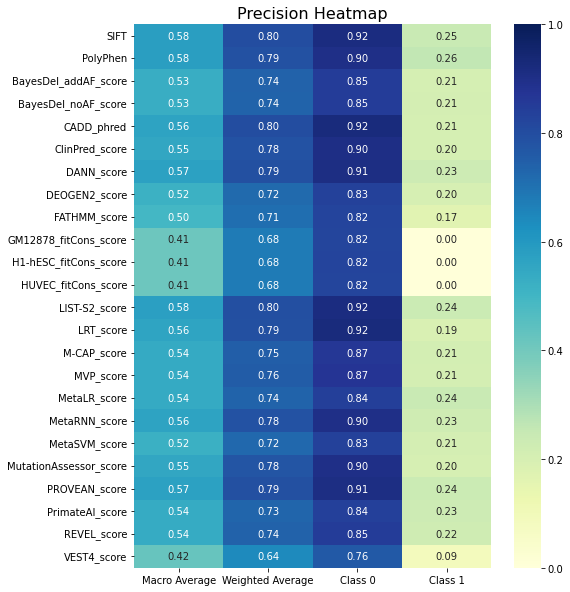

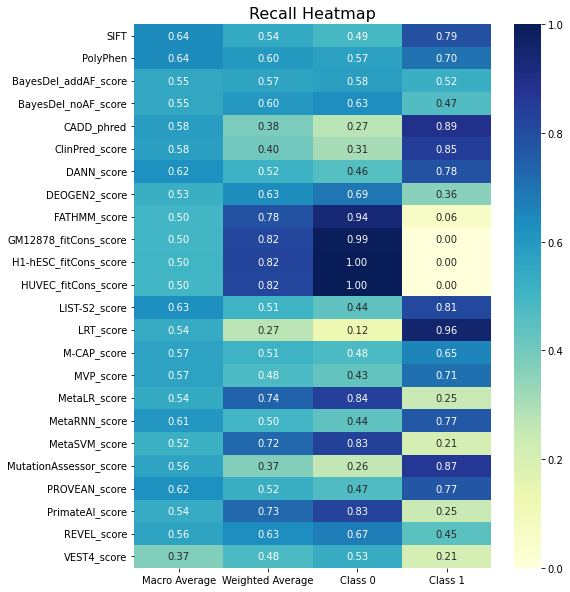

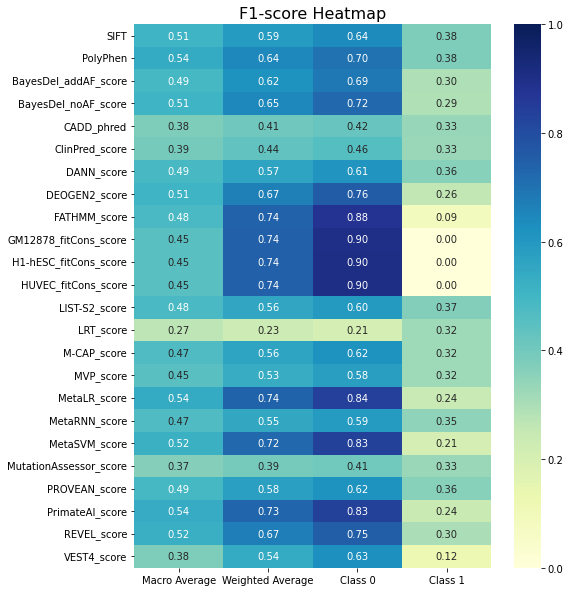

In [21]:
# create a heatmap for precision, recall, and f1-score
for metric in ['precision', 'recall', 'f1-score']:
    # create a figure with a larger size
    fig, ax = plt.subplots(figsize=(8, 10))

    p_df = pd.DataFrame(df[metric].values.tolist()).T
    p_df = p_df.rename(columns={0: 'Macro Average',
                                1: 'Weighted Average',
                                2: 'Class 0',
                                3: 'Class 1'})


    ax = sns.heatmap(p_df, cmap="YlGnBu", annot=True, fmt='.2f', vmin=0, vmax=1)
    # ax.set_ylabel('VEP', fontsize=14) # increase font size
    # ax.set_xlabel('Class', fontsize=14) # increase font size
    ax.set_yticklabels(sthresh['VEP'], rotation=0, fontsize=10) # set y-axis labels and rotate them to horizontal position
    # ax.set_yticks(range(len(reports_list)))
    # ax.set_xticks(range(len(data)))
    # ax.set_yticklabels(range(1, len(reports_list)+1))
    # ax.set_xticklabels(sorted(data.keys()))
    plt.title(metric.capitalize() + ' Heatmap', fontsize=16) # increase title font size
    plt.show()

In [22]:
acc_df = pd.DataFrame()
row = 0
for i in range(len(reports_list)):
    acc_df.loc[row,'VEP'] = sthresh['VEP'][i]
    acc_df.loc[row,'accuracy'] = reports_list[i]['accuracy']
    row = row +1
acc_df

,VEP,accuracy
0,SIFT,0.541016
1,PolyPhen,0.596147
2,BayesDel_addAF_score,0.566257
3,BayesDel_noAF_score,0.601129
4,CADD_phred,0.381933
5,ClinPred_score,0.400199
6,DANN_score,0.515443
7,DEOGEN2_score,0.633571
8,FATHMM_score,0.782551
9,GM12878_fitCons_score,0.819701


## play around with different 'ligand class', 'exp_func'

### for each unique category

In [52]:
t_df  = VEPwithGPCR.copy()

cate = 'exp_func'
t_df[cate] = t_df[cate].fillna('nan')

In [53]:
# get list of unique values in 'exp_func' column
unique_values = t_df[cate].unique()


In [54]:
aucroc_df = pd.DataFrame()
row = 0
for i in range(len(VEP_list)):  
    vep = sthresh['VEP'][i]
    # print('processing VEP: ',vep)
    thresh_value = sthresh['threshold'][i]
    thresh_greather = sthresh['greater than'][i]
    # create separate DataFrames for each unique value
    for val in unique_values:
        subset = t_df[t_df[cate] == val]
        temp1 = subset[subset[vep]!='-'][['mutation_pos','SYMBOL','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
        p1 = re.compile(r'[(](.*?)[)]', re.S)
        if vep == 'SIFT' or vep == 'PolyPhen':
            temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
        elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
            temp2 = temp1[vep].apply(lambda x: list(set(x.split(',')) - set(['.'])))
            temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
            temp1[vep] = temp2
            temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
        temp1[vep] = temp1[vep].astype(float)
        exp_labels = []
        pred_labels = []
        for j in range(temp1.shape[0]):
            if thresh_greather==1:
                pred_labels.append(1 if temp1[vep][j] > thresh_value else 0)
                exp_labels.append(1 if temp1['exp_fold_change'][j] < -10 or temp1['exp_fold_change'][j] > 10 else 0)
            else:
                pred_labels.append(1 if temp1[vep][j] < thresh_value else 0)
                exp_labels.append(1 if temp1['exp_fold_change'][j] < -10 or temp1['exp_fold_change'][j] > 10 else 0)        
        # # Generate classification report
        # report = classification_report(exp_labels, pred_labels, labels=[0, 1], digits=4,zero_division="warn", output_dict=True)
        # reports_list.append(report)

        # calculate FPR and TPR
        fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)
        # calculate AUCROC
        auc_roc = auc(fpr, tpr)
        # store in df
        aucroc_df.loc[row,'VEP'] = vep
        aucroc_df.loc[row, val] = auc_roc
    row = row +1

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value

In [55]:
aucroc_df

,VEP,Functional - IP accumulation,Functional - cAMP accumulation,binding,Binding - Radioligand competition/displacement,Binding - Radioligand saturation,Functional - Ca2+ accumulation,Binding - Radioligand kinetics (association/dissociation),Functional - [35S]GPTγS binding,Functional - Other,...,Ca2+ accumulaion,radioligand binding,cAMP accumulation,Calcium mobilization assay,Functional - β-arrestin recruitment,nan,Biing - Surface plasmon resonance,Functional - ERK activation,CRE-luciferase,SRE-luciferase
0,SIFT,0.608643,0.623030,0.530405,0.643429,0.600658,0.563492,0.733333,0.500000,0.504464,...,NaN,0.800000,0.846154,NaN,0.5,0.7500,0.5,0.568269,NaN,NaN
1,PolyPhen,0.635354,0.633213,0.566441,0.637598,0.663348,0.654762,0.458333,0.431818,0.630580,...,NaN,0.433333,0.661538,NaN,1.0,0.8125,0.5,0.617308,NaN,NaN
2,BayesDel_addAF_score,0.578331,0.640599,0.666667,0.552469,0.533979,0.543651,0.630556,0.431818,0.598214,...,NaN,0.433333,0.661538,NaN,1.0,0.8750,0.5,0.517308,NaN,NaN
3,BayesDel_noAF_score,0.575330,0.644999,0.695946,0.550008,0.514645,0.559524,0.730556,0.431818,0.629464,...,NaN,0.500000,0.500000,NaN,1.0,0.8750,0.5,0.528846,NaN,NaN
4,CADD_phred,0.561525,0.551881,0.558559,0.586585,0.547497,0.567460,0.633333,0.181818,0.427455,...,NaN,0.800000,0.846154,NaN,0.5,0.5625,0.5,0.446154,NaN,NaN
5,ClinPred_score,0.543517,0.554772,0.551802,0.576234,0.577640,0.563492,0.600000,0.881818,0.474330,...,NaN,0.800000,0.669231,NaN,0.5,0.5625,0.5,0.482692,NaN,NaN
6,DANN_score,0.558824,0.603412,0.487613,0.624236,0.607326,0.535714,0.438889,0.227273,0.520089,...,NaN,0.800000,0.784615,NaN,0.5,0.6250,0.5,0.505769,NaN,NaN
7,DEOGEN2_score,0.578405,0.669318,0.542373,0.527103,0.571792,0.559524,0.413889,0.295455,0.438616,...,NaN,0.933333,0.700000,NaN,0.5,1.0000,0.5,0.425962,NaN,NaN
8,FATHMM_score,0.531813,0.407294,0.594595,0.501901,0.494321,0.440476,0.377778,0.545455,0.390625,...,NaN,0.500000,0.500000,NaN,0.5,0.5000,0.5,0.425000,NaN,NaN
9,GM12878_fitCons_score,0.500000,0.500000,0.500000,0.497421,0.495726,0.500000,0.500000,0.500000,0.500000,...,NaN,0.500000,0.500000,NaN,0.5,NaN,0.5,0.500000,NaN,NaN


### for specific category

In [359]:
t_df  = VEPwithGPCR.copy()
t_df['exp_func'] = t_df['exp_func'].fillna('nan')
func_subset = t_df[t_df['exp_func'].str.contains('Functional')]
bind_subset = t_df[t_df['exp_func'].str.contains('Binding|binding')]


In [360]:
reports_list_f = []
reports_list_b = []
aucroc_df = pd.DataFrame()
row = 0
for i in range(len(VEP_list)):  
    vep = sthresh['VEP'][i]
    print('processing VEP: ',vep)
    thresh_value = sthresh['threshold'][i]
    thresh_greather = sthresh['greater than'][i]
    temp1_f = func_subset[func_subset[vep]!='-'][['mutation_pos','SYMBOL','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
    temp1_b = bind_subset[bind_subset[vep]!='-'][['mutation_pos','SYMBOL','Amino_acids',vep,'exp_fold_change']].reset_index(drop=True)
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1_f[vep] = temp1_f[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
        temp1_b[vep] = temp1_b[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2_f = temp1_f[vep].apply(lambda x: list(set(x.split(',')) - set(['.'])))
        temp2_f = temp2_f.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1_f[vep] = temp2_f
        temp1_f = temp1_f.dropna(subset=[vep]).reset_index(drop=True)

        temp2_b = temp1_b[vep].apply(lambda x: list(set(x.split(',')) - set(['.'])))
        temp2_b = temp2_b.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1_b[vep] = temp2_b
        temp1_b = temp1_b.dropna(subset=[vep]).reset_index(drop=True)
    temp1_f[vep] = temp1_f[vep].astype(float)
    exp_labels_f = []
    pred_labels_f = []

    temp1_b[vep] = temp1_b[vep].astype(float)
    exp_labels_b = []
    pred_labels_b = []

    for j in range(temp1_f.shape[0]):
        if thresh_greather==1:
            pred_labels_f.append(1 if temp1_f[vep][j] > thresh_value else 0)
            exp_labels_f.append(1 if temp1_f['exp_fold_change'][j] < -2 or temp1_f['exp_fold_change'][j] > 2 else 0)
        else:
            pred_labels_f.append(1 if temp1_f[vep][j] < thresh_value else 0)
            exp_labels_f.append(1 if temp1_f['exp_fold_change'][j] < -2 or temp1_f['exp_fold_change'][j] > 2 else 0)        
       
    for j in range(temp1_b.shape[0]):
        if thresh_greather==1:
            pred_labels_b.append(1 if temp1_b[vep][j] > thresh_value else 0)
            exp_labels_b.append(1 if temp1_b['exp_fold_change'][j] < -2 or temp1_b['exp_fold_change'][j] > 2 else 0)
        else:
            pred_labels_b.append(1 if temp1_b[vep][j] < thresh_value else 0)
            exp_labels_b.append(1 if temp1_b['exp_fold_change'][j] < -2 or temp1_b['exp_fold_change'][j] > 2 else 0)  
   
    # Generate classification report
    report_f = classification_report(exp_labels_f, pred_labels_f, labels=[0, 1], digits=4,zero_division="warn", output_dict=True)
    reports_list_f.append(report_f)
    report_b = classification_report(exp_labels_b, pred_labels_b, labels=[0, 1], digits=4,zero_division="warn", output_dict=True)
    reports_list_b.append(report_b)
    
    # calculate FPR and TPR
    fpr_f, tpr_f, thresholds_f = roc_curve(exp_labels_f, pred_labels_f)
    fpr_b, tpr_b, thresholds_b = roc_curve(exp_labels_b, pred_labels_b)
    # calculate AUCROC
    auc_roc_f = auc(fpr_f, tpr_f)
    auc_roc_b = auc(fpr_b, tpr_b)
    # store in df
    aucroc_df.loc[row,'VEP'] = vep
    aucroc_df.loc[row, 'functional-AUCROC'] = auc_roc_f
    aucroc_df.loc[row, 'binding-AUCROC'] = auc_roc_b
    row = row +1

processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing VEP:  DEOGEN2_score
processing VEP:  FATHMM_score
processing VEP:  integrated_fitCons_score
processing VEP:  LIST-S2_score
processing VEP:  LRT_score
processing VEP:  M-CAP_score
processing VEP:  MVP_score
processing VEP:  MetaLR_score
processing VEP:  MetaRNN_score
processing VEP:  MetaSVM_score
processing VEP:  MutationAssessor_score
processing VEP:  PROVEAN_score
processing VEP:  PrimateAI_score
processing VEP:  REVEL_score
processing VEP:  VEST4_score
processing VEP:  GERP++_RS
processing VEP:  SiPhy_29way_logOdds
processing VEP:  MutPred_score


In [361]:
aucroc_df

,VEP,functional-AUCROC,binding-AUCROC
0,SIFT,0.567551,0.582742
1,PolyPhen,0.566262,0.586070
2,BayesDel_addAF_score,0.552610,0.554496
3,BayesDel_noAF_score,0.550972,0.551026
4,CADD_phred,0.519598,0.551341
5,ClinPred_score,0.527066,0.561795
6,DANN_score,0.542872,0.568026
7,DEOGEN2_score,0.541342,0.518432
8,FATHMM_score,0.488403,0.497924
9,integrated_fitCons_score,0.499294,0.499682


In [76]:
reports_list = reports_list_b
# initialize data dictionary to store precision, recall, and f1-score for each class label and averages
data = {'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}
for report in reports_list:
    for class_label, metrics in report.items():
        if class_label in ['macro avg', 'weighted avg']:
            for metric, value in metrics.items():
                if metric!='support':
                    data[class_label][metric].append(value)
        elif class_label.isdigit():
            if class_label not in data:
                data[class_label] = {'precision': [], 'recall': [], 'f1-score': []}
            data[class_label]['precision'].append(metrics['precision'])
            data[class_label]['recall'].append(metrics['recall'])
            data[class_label]['f1-score'].append(metrics['f1-score'])

# convert data dictionary to pandas DataFrame for easier manipulation and plotting
df = pd.DataFrame.from_dict(data, orient='index')

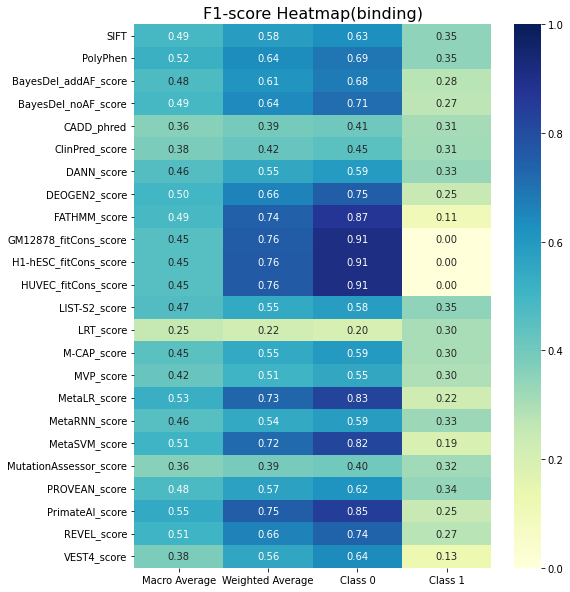

In [77]:
# create a figure with a larger size
fig, ax = plt.subplots(figsize=(8, 10))

p_df = pd.DataFrame(df['f1-score'].values.tolist()).T
p_df = p_df.rename(columns={0: 'Macro Average',
                            1: 'Weighted Average',
                            2: 'Class 0',
                            3: 'Class 1'})


ax = sns.heatmap(p_df, cmap="YlGnBu", annot=True, fmt='.2f', vmin=0, vmax=1)
# ax.set_ylabel('VEP', fontsize=14) # increase font size
# ax.set_xlabel('Class', fontsize=14) # increase font size
ax.set_yticklabels(sthresh['VEP'], rotation=0, fontsize=10) # set y-axis labels and rotate them to horizontal position
# ax.set_yticks(range(len(reports_list)))
# ax.set_xticks(range(len(data)))
# ax.set_yticklabels(range(1, len(reports_list)+1))
# ax.set_xticklabels(sorted(data.keys()))
plt.title('f1-score'.capitalize() + ' Heatmap(binding)', fontsize=16) # increase title font size
plt.show()